# Information Systems Project - How Does Momentum Affect Premier League Match Results?
#### Christian Gottlieb and Michael Porter

## Motivation

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress

## Scraping the Premier League match results for the 2020-21, 2021-22, 2022-23, 2023-24, and 2024-25 seasons and putting in a dataframe

In [3]:
base_url = "https://fixturedownload.com/view/json/epl-"

In [4]:
raw_matches_df = pd.DataFrame()
# looping through the websites for the premier league match results for the 20-21, 21-22, 22-23, 23-24, and 24-25 seasons
for year in range(2020,2025):
    year_url = base_url + str(year)
    year_website = requests.get(year_url)        
    soup = BeautifulSoup(year_website.content, 'html.parser')
    data = soup.find('textarea')
    data_text = data.get_text()
    curr_season_matches_df = pd.read_json(data_text)
    curr_season_matches_df['Season'] = str(year) + '-' + str(year+1) # Adding Season Column
    raw_matches_df = pd.concat([raw_matches_df, curr_season_matches_df])

C:\Users\ckgottlieb\AppData\Local\Temp\ipykernel_23020\2458789591.py:9: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  curr_season_matches_df = pd.read_json(data_text)
C:\Users\ckgottlieb\AppData\Local\Temp\ipykernel_23020\2458789591.py:9: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  curr_season_matches_df = pd.read_json(data_text)
C:\Users\ckgottlieb\AppData\Local\Temp\ipykernel_23020\2458789591.py:9: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  curr_season_matches_df = pd.read_json(data_text)
C:\Users\ckgottlieb\AppData\Local\Temp\ipykernel_23020\2458789591.py:9: FutureWarning: Passing literal json to 'read_json' i

In [5]:
raw_matches_df.head()

,MatchNumber,RoundNumber,DateUtc,Location,HomeTeam,AwayTeam,Group,HomeTeamScore,AwayTeamScore,Season
0,4,1,2020-09-12 11:30:00Z,Craven Cottage,Fulham,Arsenal,NaN,0,3,2020-2021
1,3,1,2020-09-12 14:00:00Z,Selhurst Park,Crystal Palace,Southampton,NaN,1,0,2020-2021
2,5,1,2020-09-12 16:30:00Z,Anfield,Liverpool,Leeds,NaN,4,3,2020-2021
3,8,1,2020-09-12 19:00:00Z,London Stadium,West Ham,Newcastle,NaN,0,2,2020-2021
4,7,1,2020-09-13 13:00:00Z,The Hawthorns,West Brom,Leicester,NaN,0,3,2020-2021


In [6]:
len(raw_matches_df)

1900

In [7]:
print(1900/5)

380.0


We see that there are 1900 total matches in the dataframe. We have the data for 5 seasons, so this is what we expect because there is 380 matches per season (38 weeks and 10 matches per week).

## Transforming the Dataframe

In [8]:
# Removing Group column 
raw_matches_df = raw_matches_df.drop('Group', axis = 1)

In [9]:
# Renaming RoundNumber and DateUtc to WeekNumber and Date
col_names = list(raw_matches_df.columns)
col_names[1:3] = ['WeekNumber','Date']
raw_matches_df.columns = col_names

In [10]:
# Nottingham Forest is listed like Nott'm Forest in one season so changing this to Nottingham Forest like it is named in the rest of the seasons
raw_matches_df['HomeTeam'] = raw_matches_df['HomeTeam'].replace({"Nott'm Forest": 'Nottingham Forest'})
raw_matches_df['AwayTeam'] = raw_matches_df['AwayTeam'].replace({"Nott'm Forest": 'Nottingham Forest'})

In [11]:
# Reordering columns
raw_matches_df = raw_matches_df.reindex(columns = ['WeekNumber','MatchNumber','HomeTeam','AwayTeam','HomeTeamScore','AwayTeamScore','Location','Date','Season'])

In [12]:
# Updated dataframe
raw_matches_df.head()

,WeekNumber,MatchNumber,HomeTeam,AwayTeam,HomeTeamScore,AwayTeamScore,Location,Date,Season
0,1,4,Fulham,Arsenal,0,3,Craven Cottage,2020-09-12 11:30:00Z,2020-2021
1,1,3,Crystal Palace,Southampton,1,0,Selhurst Park,2020-09-12 14:00:00Z,2020-2021
2,1,5,Liverpool,Leeds,4,3,Anfield,2020-09-12 16:30:00Z,2020-2021
3,1,8,West Ham,Newcastle,0,2,London Stadium,2020-09-12 19:00:00Z,2020-2021
4,1,7,West Brom,Leicester,0,3,The Hawthorns,2020-09-13 13:00:00Z,2020-2021


## Creating Second Dataframe where each match is represented twice - once for each time
##### * This is to keep track of momentum data for the teams

In [13]:
# First creating a dataframe of for all the home teams
home_teams_df = pd.DataFrame(raw_matches_df)

In [14]:
# Renaming columns 
col_names = list(home_teams_df.columns)
col_names[2:6] = ['Team','Opponent','TeamGoals','OpponentGoals']
home_teams_df.columns = col_names

In [15]:
# Adding Home/Away Column (all the teams in this dataframe are home)
home_teams_df['Home/Away'] = 'Home'

In [16]:
home_teams_df.head()

,WeekNumber,MatchNumber,Team,Opponent,TeamGoals,OpponentGoals,Location,Date,Season,Home/Away
0,1,4,Fulham,Arsenal,0,3,Craven Cottage,2020-09-12 11:30:00Z,2020-2021,Home
1,1,3,Crystal Palace,Southampton,1,0,Selhurst Park,2020-09-12 14:00:00Z,2020-2021,Home
2,1,5,Liverpool,Leeds,4,3,Anfield,2020-09-12 16:30:00Z,2020-2021,Home
3,1,8,West Ham,Newcastle,0,2,London Stadium,2020-09-12 19:00:00Z,2020-2021,Home
4,1,7,West Brom,Leicester,0,3,The Hawthorns,2020-09-13 13:00:00Z,2020-2021,Home


In [17]:
# Next creating a dataframe for all the away teams
away_teams_df = pd.DataFrame(raw_matches_df)

In [18]:
# Renaming the columns
col_names = list(away_teams_df.columns)
col_names[2:6] = ['Opponent','Team','OpponentGoals','TeamGoals'] # Here the HomeTeam correlates with Opponent and AwayTeam corrolates with Team
away_teams_df.columns = col_names

In [19]:
away_teams_df['Home/Away'] = 'Away'

In [20]:
away_teams_df.head()

,WeekNumber,MatchNumber,Opponent,Team,OpponentGoals,TeamGoals,Location,Date,Season,Home/Away
0,1,4,Fulham,Arsenal,0,3,Craven Cottage,2020-09-12 11:30:00Z,2020-2021,Away
1,1,3,Crystal Palace,Southampton,1,0,Selhurst Park,2020-09-12 14:00:00Z,2020-2021,Away
2,1,5,Liverpool,Leeds,4,3,Anfield,2020-09-12 16:30:00Z,2020-2021,Away
3,1,8,West Ham,Newcastle,0,2,London Stadium,2020-09-12 19:00:00Z,2020-2021,Away
4,1,7,West Brom,Leicester,0,3,The Hawthorns,2020-09-13 13:00:00Z,2020-2021,Away


In [21]:
# Combining home_teams_df and away_teams_df to create dataframe where each match is represented twice (once for each team)
df = pd.concat([home_teams_df, away_teams_df])

In [22]:
df.head()

,WeekNumber,MatchNumber,Team,Opponent,TeamGoals,OpponentGoals,Location,Date,Season,Home/Away
0,1,4,Fulham,Arsenal,0,3,Craven Cottage,2020-09-12 11:30:00Z,2020-2021,Home
1,1,3,Crystal Palace,Southampton,1,0,Selhurst Park,2020-09-12 14:00:00Z,2020-2021,Home
2,1,5,Liverpool,Leeds,4,3,Anfield,2020-09-12 16:30:00Z,2020-2021,Home
3,1,8,West Ham,Newcastle,0,2,London Stadium,2020-09-12 19:00:00Z,2020-2021,Home
4,1,7,West Brom,Leicester,0,3,The Hawthorns,2020-09-13 13:00:00Z,2020-2021,Home


## Transforming New Dataframe

In [23]:
df['GoalDifferential'] = df['TeamGoals'] - df['OpponentGoals']

In [24]:
# Reordering by date
df = df.sort_values(by = 'Date')

In [25]:
# Giving each row a unique ID
df['ID'] = [i for i in range(1,len(df)+1)]
df = df.set_index(df['ID'])

In [26]:
# Adding result and points column (using goal differential to calculate) (0 points for loss, 1 point for tie, 3 points for win)
def result(num):
    if num < 0:
        result = "L"
    elif num == 0:
        result = "T"
    else:
        result = "W"
    return result

def points(num):
    if num < 0:
        points = 0
    elif num == 0:
        points = 1
    else:
        points = 3
    return points
    
for col, func in {'Result':result, 'Points':points}.items():
    df[col] = df['GoalDifferential'].apply(func) 

In [27]:
# Reordering columns
df = df.reindex(columns = ['WeekNumber','MatchNumber','Team','Opponent','TeamGoals','OpponentGoals','Result','Points','GoalDifferential','Home/Away','Location','Date','Season'])

In [28]:
df.head()

,WeekNumber,MatchNumber,Team,Opponent,TeamGoals,OpponentGoals,Result,Points,GoalDifferential,Home/Away,Location,Date,Season
ID,,,,,,,,,,,,,
1,1,4,Fulham,Arsenal,0,3,L,0,-3,Home,Craven Cottage,2020-09-12 11:30:00Z,2020-2021
2,1,4,Arsenal,Fulham,3,0,W,3,3,Away,Craven Cottage,2020-09-12 11:30:00Z,2020-2021
3,1,3,Southampton,Crystal Palace,0,1,L,0,-1,Away,Selhurst Park,2020-09-12 14:00:00Z,2020-2021
4,1,3,Crystal Palace,Southampton,1,0,W,3,1,Home,Selhurst Park,2020-09-12 14:00:00Z,2020-2021
5,1,5,Liverpool,Leeds,4,3,W,3,1,Home,Anfield,2020-09-12 16:30:00Z,2020-2021


In [29]:
# Creating last n points columns (how many points earned in last n matches (note: this is before the match in the current row))
def add_last_n_points_column(n):
    df['Last' + str(n) + 'Points'] = 0 # initializing lastnpoints column
    for team in list(df['Team'].unique()): # Looping through teams
        for season in list(df['Season'].unique()): # Looping through seasons
            curr_df = df[(df['Team'] == team) & (df['Season'] == season)] # Filtering to only get one team in one season at a time
            for i in range(len(curr_df)):
                lastnpoints = 0
                if i > n-1: # Checking if n game have already been played or not (i represents the row # in this case and because curr_df is only one team in one season this represents the week # as well)
                    for j in range(i-n,i):
                        lastnpoints += curr_df.iloc[j,7] # The 7th column is points
                else: # If not, add all of the points that have been earned so far
                    for j in range(0,i): 
                        lastnpoints += curr_df.iloc[j,7]
                df.loc[curr_df.index[i],'Last' + str(n) + 'Points'] = lastnpoints # Adding to df (grabbing ID to do this)
                #df.loc[list(curr_df['ID'].unique())[i],'Last' + str(n) + 'Points'] = lastnpoints # Adding to df (getting ID to do this)

# Adding last3points column and last5points column
add_last_n_points_column(3)
add_last_n_points_column(5)

In [30]:
# Just looking at Arsenal to see that this worked
df[df['Team'] == 'Arsenal'].head(10)

,WeekNumber,MatchNumber,Team,Opponent,TeamGoals,OpponentGoals,Result,Points,GoalDifferential,Home/Away,Location,Date,Season,Last3Points,Last5Points
ID,,,,,,,,,,,,,,,
2,1,4,Arsenal,Fulham,3,0,W,3,3,Away,Craven Cottage,2020-09-12 11:30:00Z,2020-2021,0,0
23,2,11,Arsenal,West Ham,2,1,W,3,1,Home,Emirates Stadium,2020-09-19 19:00:00Z,2020-2021,3,3
55,3,25,Arsenal,Liverpool,1,3,L,0,-2,Away,Anfield,2020-09-28 19:00:00Z,2020-2021,6,6
72,4,31,Arsenal,Sheffield Utd,2,1,W,3,1,Home,Emirates Stadium,2020-10-04 13:00:00Z,2020-2021,6,6
81,5,46,Arsenal,Man City,0,1,L,0,-1,Away,Etihad Stadium,2020-10-17 16:30:00Z,2020-2021,6,9
111,6,51,Arsenal,Leicester,0,1,L,0,-1,Home,Emirates Stadium,2020-10-25 19:15:00Z,2020-2021,3,9
130,7,66,Arsenal,Man Utd,1,0,W,3,1,Away,Old Trafford,2020-11-01 16:30:00Z,2020-2021,3,6
156,8,71,Arsenal,Aston Villa,0,3,L,0,-3,Home,Emirates Stadium,2020-11-08 19:15:00Z,2020-2021,3,6
169,9,84,Arsenal,Leeds,0,0,T,1,0,Away,Elland Road,2020-11-22 16:30:00Z,2020-2021,3,6


In [31]:
# Creating last n goal differential columns (the goal differential over the last n matches (note: this is before the match in the current row))
# This function is very similiar to add_last_n_points_column
def add_last_n_gd_column(n):
    df['Last' + str(n) + 'GD'] = 0 # initializing lastnpoints column
    for team in list(df['Team'].unique()): # Looping through teams
        for season in list(df['Season'].unique()): # Looping through seasons
            curr_df = df[(df['Team'] == team) & (df['Season'] == season)] # Filtering to only get one team in one season at a time
            for i in range(len(curr_df)):
                lastnGD = 0
                if i > n-1: # Checking if n game have already been played or not (i represents the row # in this case and because curr_df is only one team in one season this represents the week # as well)
                    for j in range(i-n,i):
                        lastnGD += curr_df.iloc[j,8] # The 8th column is points
                else: # If not, add all of the points that have been earned so far
                    for j in range(0,i): 
                        lastnGD += curr_df.iloc[j,8]
                df.loc[curr_df.index[i],'Last' + str(n) + 'GD'] = lastnGD # Adding to df

# Adding last3GD column and last5GD column
add_last_n_gd_column(3)
add_last_n_gd_column(5)

In [32]:
'''
# Creating winstreak column
def add_winstreak_column():
    df['WinStreakBefore'] = 0 # initializing winstreak column
    for team in list(df['Team'].unique()): # Looping through teams
        for season in list(df['Season'].unique()): # Looping through seasons
            curr_df = df[(df['Team'] == team) & (df['Season'] == season)] # Filtering to only get one team in one season at a time
            winstreak = 0
            for i in range(len(curr_df)):
                if i > 0: # Making sure it's not the first game
                    if curr_df.iloc[i-1,6] == 'W':
                        winstreak += 1
                    else:
                        winstreak = 0
                df.loc[curr_df.index[i],'WinStreakBefore'] = winstreak # Adding to df

add_winstreak_column()
'''

In [33]:
'''
# Creating unbeatenstreak column
def add_unbeatenstreak_column():
    df['UnbeatenStreakBefore'] = 0 # initializing winstreak column
    for team in list(df['Team'].unique()): # Looping through teams
        for season in list(df['Season'].unique()): # Looping through seasons
            curr_df = df[(df['Team'] == team) & (df['Season'] == season)] # Filtering to only get one team in one season at a time
            unbeatenstreak = 0
            for i in range(len(curr_df)):
                if i > 0: # Making sure it's not the first game
                    if curr_df.iloc[i-1,6] in ['W', 'T']:
                        unbeatenstreak += 1
                    else:
                        unbeatenstreak = 0
                df.loc[curr_df.index[i],'UnbeatenStreakBefore'] = unbeatenstreak

add_unbeatenstreak_column()
'''

In [34]:
'''
# Creating unbeatenstreak column
def add_lossstreak_column():
    df['LossStreakBefore'] = 0 # initializing winstreak column
    for team in list(df['Team'].unique()): # Looping through teams
        for season in list(df['Season'].unique()): # Looping through seasons
            curr_df = df[(df['Team'] == team) & (df['Season'] == season)] # Filtering to only get one team in one season at a time
            loss_streak = 0
            for i in range(len(curr_df)):
                if i > 0: # Making sure it's not the first game
                    if curr_df.iloc[i-1,6] == 'L':
                        loss_streak += 1
                    else:
                        loss_streak = 0
                df.loc[curr_df.index[i],'LossStreakBefore'] = loss_streak # Adding to df

add_lossstreak_column()
'''

In [35]:
'''
# Creating games since win column (this restarts at the beggining of the season - ie. if a team doesn't win the first 5 games, this will be 5 even if 
# they lost the last game the year before)
def add_gamessincewin_column():
    df['GamesSinceWin'] = 0 # initializing winstreak column
    for team in list(df['Team'].unique()): # Looping through teams
        for season in list(df['Season'].unique()): # Looping through seasons
            curr_df = df[(df['Team'] == team) & (df['Season'] == season)] # Filtering to only get one team in one season at a time
            games_since_win = 0
            for i in range(len(curr_df)):
                if i > 0: # Making sure it's not the first game
                    if curr_df.iloc[i-1,6] in ['L','T']:
                        games_since_win += 1
                    else:
                        games_since_win = 0
                df.loc[curr_df.index[i],'GamesSinceWin'] = games_since_win # adding to df

add_gamessincewin_column()
'''

In [36]:
'''
streaks_dict = {'WinStreakBefore': ['W'], 'UnbeatenStreakBefore': ['W','T'], 'LossStreakBefore': ['L'], 'GamesSinceWin': ['L','T']} 
b = streaks_dict.keys()
'''

In [37]:
'''
df = df.drop('LossStreakBefore', axis=1)
'''

In [38]:
df.head()

,WeekNumber,MatchNumber,Team,Opponent,TeamGoals,OpponentGoals,Result,Points,GoalDifferential,Home/Away,Location,Date,Season,Last3Points,Last5Points,Last3GD,Last5GD,WinStreakBefore,UnbeatenStreakBefore,GamesSinceWin
ID,,,,,,,,,,,,,,,,,,,,
1,1,4,Fulham,Arsenal,0,3,L,0,-3,Home,Craven Cottage,2020-09-12 11:30:00Z,2020-2021,0,0,0,0,0,0,0
2,1,4,Arsenal,Fulham,3,0,W,3,3,Away,Craven Cottage,2020-09-12 11:30:00Z,2020-2021,0,0,0,0,0,0,0
3,1,3,Southampton,Crystal Palace,0,1,L,0,-1,Away,Selhurst Park,2020-09-12 14:00:00Z,2020-2021,0,0,0,0,0,0,0
4,1,3,Crystal Palace,Southampton,1,0,W,3,1,Home,Selhurst Park,2020-09-12 14:00:00Z,2020-2021,0,0,0,0,0,0,0
5,1,5,Liverpool,Leeds,4,3,W,3,1,Home,Anfield,2020-09-12 16:30:00Z,2020-2021,0,0,0,0,0,0,0


In [40]:
# Creating streak columns (These restarts at the beggining of the season - ie. if a team doesn't win the first 5 games, the loss streak before 
# will be 5 even if they lost the last game the year before)
def add_streak_columns(streaks_dict):
    for key in streaks_dict.keys():
        df[key] = 0 # initializing streak columns
    for team in list(df['Team'].unique()): # Looping through teams
        for season in list(df['Season'].unique()): # Looping through seasons
            curr_df = df[(df['Team'] == team) & (df['Season'] == season)] # Filtering to only get one team in one season at a time
            for key, value in streaks_dict.items():
                curr_streak = 0
                for i in range(len(curr_df)):
                    if i > 0: # Making sure it's not the first game
                        if curr_df.iloc[i-1,6] in value: # value is a list
                            curr_streak += 1
                        else:
                            curr_streak = 0
                    df.loc[curr_df.index[i],key] = curr_streak # Adding to df


# streaks dictionary for streak_column function: the keys are the columns names, the values are lists containing the criteria for the streak
streaks_dict = {'WinStreakBefore': ['W'], 'UnbeatenStreakBefore': ['W','T'], 'LossStreakBefore': ['L'], 'GamesSinceWin': ['L','T']} 

add_streak_columns(streaks_dict)


In [41]:
df.head()

,WeekNumber,MatchNumber,Team,Opponent,TeamGoals,OpponentGoals,Result,Points,GoalDifferential,Home/Away,...,Date,Season,Last3Points,Last5Points,Last3GD,Last5GD,WinStreakBefore,UnbeatenStreakBefore,GamesSinceWin,LossStreakBefore
ID,,,,,,,,,,,,,,,,,,,,,
1,1,4,Fulham,Arsenal,0,3,L,0,-3,Home,...,2020-09-12 11:30:00Z,2020-2021,0,0,0,0,0,0,0,0
2,1,4,Arsenal,Fulham,3,0,W,3,3,Away,...,2020-09-12 11:30:00Z,2020-2021,0,0,0,0,0,0,0,0
3,1,3,Southampton,Crystal Palace,0,1,L,0,-1,Away,...,2020-09-12 14:00:00Z,2020-2021,0,0,0,0,0,0,0,0
4,1,3,Crystal Palace,Southampton,1,0,W,3,1,Home,...,2020-09-12 14:00:00Z,2020-2021,0,0,0,0,0,0,0,0
5,1,5,Liverpool,Leeds,4,3,W,3,1,Home,...,2020-09-12 16:30:00Z,2020-2021,0,0,0,0,0,0,0,0


In [42]:
# Checking Chelsea in 2024-2025 to make sure everything worked
df[(df['Team'] == 'Chelsea') & (df['Season'] == '2024-2025')].head(10)

,WeekNumber,MatchNumber,Team,Opponent,TeamGoals,OpponentGoals,Result,Points,GoalDifferential,Home/Away,...,Date,Season,Last3Points,Last5Points,Last3GD,Last5GD,WinStreakBefore,UnbeatenStreakBefore,GamesSinceWin,LossStreakBefore
ID,,,,,,,,,,,,,,,,,,,,,
3057,1,9,Chelsea,Man City,0,2,L,0,-2,Home,...,2024-08-18 15:30:00Z,2024-2025,0,0,0,0,0,0,0,0
3078,2,20,Chelsea,Wolves,6,2,W,3,4,Away,...,2024-08-25 13:00:00Z,2024-2025,0,0,-2,-2,0,0,1,1
3097,3,23,Chelsea,Crystal Palace,1,1,T,1,0,Home,...,2024-09-01 12:30:00Z,2024-2025,3,3,2,2,1,1,0,0
3115,4,32,Chelsea,Bournemouth,1,0,W,3,1,Away,...,2024-09-14 19:00:00Z,2024-2025,4,4,2,2,0,2,1,0
3121,5,50,Chelsea,West Ham,3,0,W,3,3,Away,...,2024-09-21 11:30:00Z,2024-2025,7,7,5,3,1,3,0,0
3152,6,54,Chelsea,Brighton,4,2,W,3,2,Home,...,2024-09-28 14:00:00Z,2024-2025,7,10,4,6,2,4,0,0
3175,7,65,Chelsea,Nottingham Forest,1,1,T,1,0,Home,...,2024-10-06 13:00:00Z,2024-2025,9,13,6,10,3,5,0,0
3198,8,74,Chelsea,Liverpool,1,2,L,0,-1,Away,...,2024-10-20 15:30:00Z,2024-2025,7,11,5,6,0,6,1,0
3218,9,85,Chelsea,Newcastle,2,1,W,3,1,Home,...,2024-10-27 14:00:00Z,2024-2025,4,10,1,5,0,0,2,1


## 1. Does Win Streak Predict the Outcome of the next match?

In [43]:
# Creating dataframe of results by winstreak to do analysis
win_streaks = df.groupby('WinStreakBefore')
win_streak_counts = win_streaks.size()
result_by_winstreak = win_streak_counts.to_frame() # Transforming series of win streak counts to dataframe
result_by_winstreak.columns = ['SampleSize'] # Naming column
result_by_winstreak['WinPercentage'] = (df.groupby('WinStreakBefore')['Result'].apply(lambda x: (x == 'W').mean())) # Calculating WinPercentage by WinStreak
result_by_winstreak['TiePercentage'] = (df.groupby('WinStreakBefore')['Result'].apply(lambda x: (x == 'T').mean())) # Calculating TiePercentage by WinStreak
result_by_winstreak['LossPercentage'] = (df.groupby('WinStreakBefore')['Result'].apply(lambda x: (x == 'L').mean())) # Calculating LossPercentage by WinStreak

In [44]:
result_by_winstreak

,SampleSize,WinPercentage,TiePercentage,LossPercentage
WinStreakBefore,,,,
0,2378,0.357864,0.224138,0.417998
1,827,0.390568,0.235792,0.373640
2,315,0.463492,0.225397,0.311111
3,140,0.478571,0.264286,0.257143
4,65,0.492308,0.215385,0.292308
5,29,0.551724,0.206897,0.241379
6,15,0.533333,0.266667,0.200000
7,8,0.750000,0.250000,0.000000
8,6,0.833333,0.166667,0.000000


### a) Looking at Just Win Percentage by Win Streak

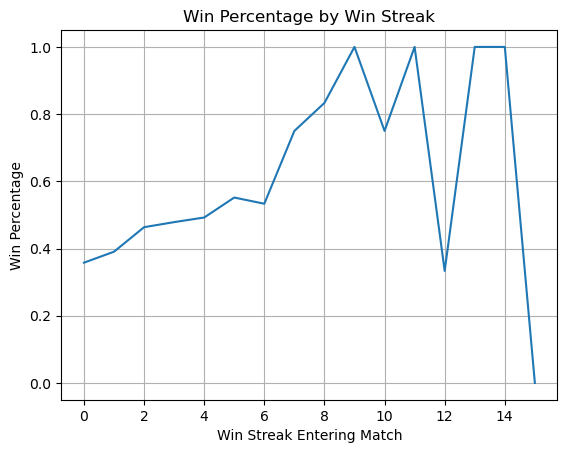

In [45]:
plt.plot(result_by_winstreak.index, result_by_winstreak['WinPercentage'])
plt.xlabel("Win Streak Entering Match")
plt.ylabel("Win Percentage")
plt.title("Win Percentage by Win Streak")
plt.grid(True)
plt.show()

We see a correlation, when winstreak is between 0 and 9, but then the win percentage is all over the place when the sample size is low

#### What if we got rid of data that didn't have a big enough sample size?

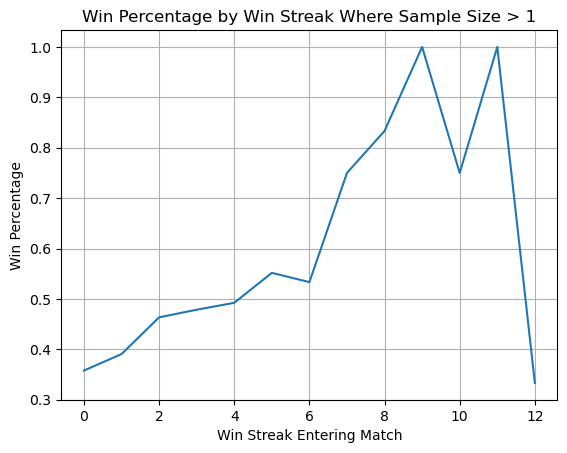

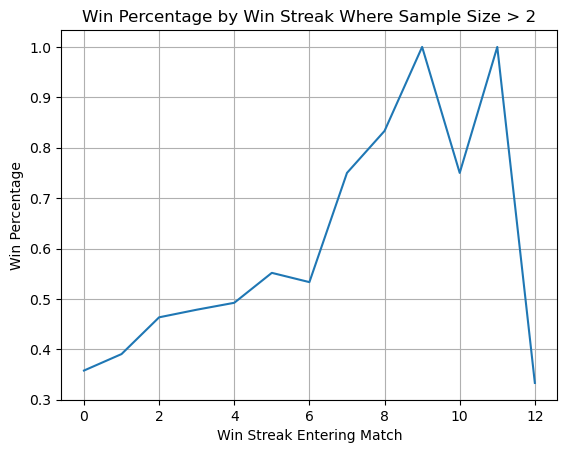

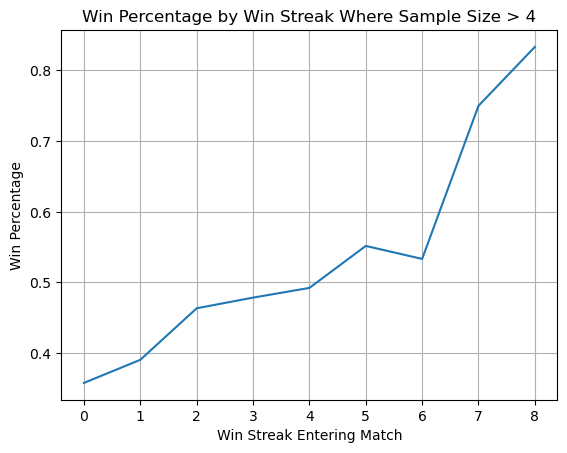

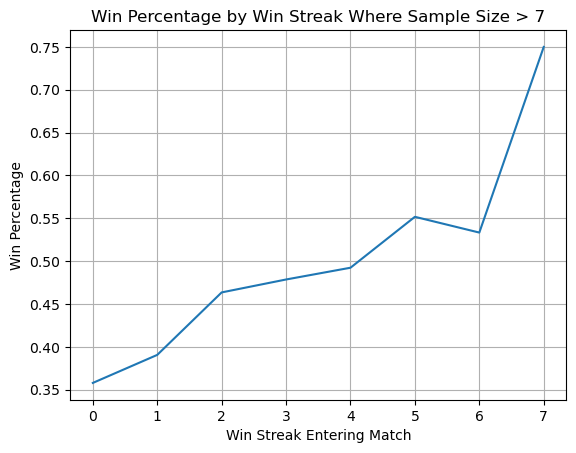

In [46]:
sample_size_mins = [2,3,5,8]
for num in sample_size_mins: 
    mask = result_by_winstreak['SampleSize'] >= num # requiring minimum samplesize
    reduced_data = result_by_winstreak[mask]
    plt.plot(reduced_data.index, reduced_data['WinPercentage'])
    plt.xlabel("Win Streak Entering Match")
    plt.ylabel("Win Percentage")
    plt.title("Win Percentage by Win Streak Where Sample Size > " + str(num-1))
    plt.grid(True)
    plt.show()

It is evident that there is a correlation between win percentage and win streak, when we required a minimum sample size. We get the best results when the minimum sample size is 4.

#### Using a minimum sample size of 4, lets add a linear regression line (using seaborn)

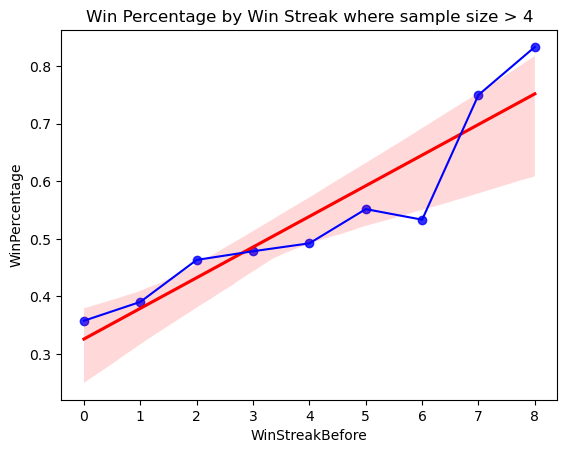

In [47]:
mask = result_by_winstreak['SampleSize'] > 4
reduced_data = result_by_winstreak[mask]
sns.regplot(x=reduced_data.index, y=reduced_data['WinPercentage'], color='blue', line_kws={"color": "red"})
plt.plot(reduced_data.index, reduced_data['WinPercentage'], color='blue')
plt.title("Win Percentage by Win Streak where sample size > 4")
plt.show()

We can see a clear correlation bwteen win streak and win percentage

In [48]:
# Calculating the slope, intercept, and r-value of the regression line
x = reduced_data.index.values
y = reduced_data['WinPercentage'].values

reg_line = linregress(x, y)

print('Slope:', reg_line.slope)
print('Intercept:', reg_line.intercept)
print('R-value:', reg_line.rvalue)

Slope: 0.05321681034153181
Intercept: 0.3261543207723514
R-value: 0.9270352434119623


This tells us that we can expect the win % to increase by about 5.3 % for each additional win in a team's win streak. There is a very strong correlation between WinStreakBefore and WinPercentage (an r-value of 0.927!)

### b) Let's look at all results based on winstreak

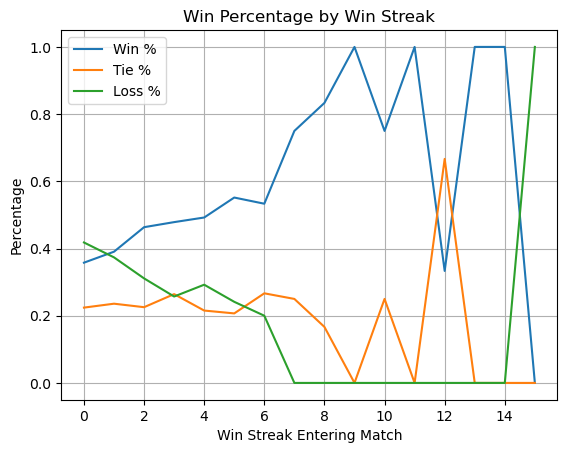

In [49]:
plt.plot(result_by_winstreak.index, result_by_winstreak['WinPercentage'], label = 'Win %')
plt.plot(result_by_winstreak.index, result_by_winstreak['TiePercentage'], label = 'Tie %')
plt.plot(result_by_winstreak.index, result_by_winstreak['LossPercentage'], label = 'Loss %')
plt.xlabel("Win Streak Entering Match")
plt.ylabel("Percentage")
plt.title("Win Percentage by Win Streak")
plt.grid(True)
plt.legend()
plt.show()

#### Let's get ride of data where the sample size is < 5

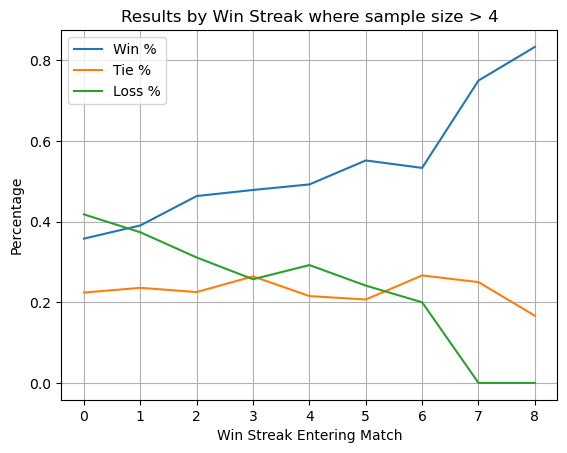

In [50]:
mask = result_by_winstreak['SampleSize'] >= 5
reduced_data = result_by_winstreak[mask]
plt.plot(reduced_data.index, reduced_data['WinPercentage'], label = 'Win %')
plt.plot(reduced_data.index, reduced_data['TiePercentage'], label = 'Tie %')
plt.plot(reduced_data.index, reduced_data['LossPercentage'], label = 'Loss %')
plt.xlabel("Win Streak Entering Match")
plt.ylabel("Percentage")
plt.title("Results by Win Streak where sample size > 4")
plt.grid(True)
plt.legend()
plt.show()

We can see that the win % increases as the win streak goes up, and the loss % decreases as the win streak goes up. The tie % doesn't seem to be affected

#### Adding Linear Regression Lines

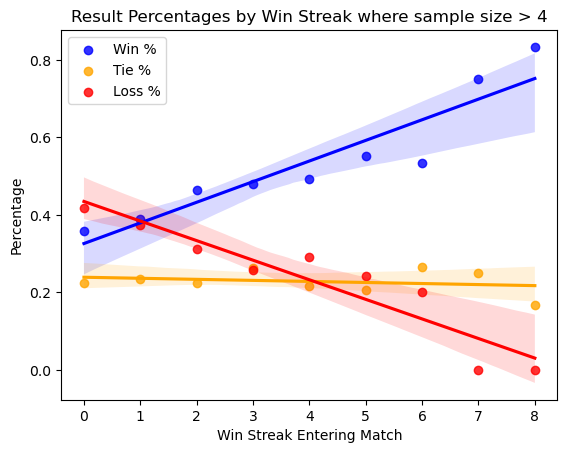

In [51]:
mask = result_by_winstreak['SampleSize'] > 4
reduced_data = result_by_winstreak[mask]
sns.regplot(x=reduced_data.index, y=reduced_data['WinPercentage'], color='blue', line_kws={'color': 'blue'}, label = 'Win %')
sns.regplot(x=reduced_data.index, y=reduced_data['TiePercentage'], color='orange', line_kws={'color': 'orange'}, label = 'Tie %')
sns.regplot(x=reduced_data.index, y=reduced_data['LossPercentage'], color='red', line_kws={'color': 'red'}, label = 'Loss %')
plt.xlabel("Win Streak Entering Match")
plt.ylabel("Percentage")
plt.title("Result Percentages by Win Streak where sample size > 4")
plt.legend()
plt.show()

In [52]:
# Calculating the slopem intercept, and r-value of the linear regression lines
x = reduced_data.index.values
reg_data = {'Win': reduced_data['WinPercentage'].values, 'Tie': reduced_data['TiePercentage'].values, 'Loss': reduced_data['LossPercentage'].values}
for name, y in reg_data.items():
    reg_line = linregress(x, y)
    print(name, "Slope:", reg_line.slope)
    print(name, "Intercept:", reg_line.intercept)
    print(name, "R-value:", reg_line.rvalue)

Win Slope: 0.05321681034153181
Win Intercept: 0.3261543207723514
Win R-value: 0.9270352434119623
Tie Slope: -0.0027018432589045113
Tie Intercept: 0.23916592753630095
Tie R-value: -0.23783340027895108
Loss Slope: -0.05051496708262731
Loss Intercept: 0.43467975169134765
Loss R-value: -0.9381973056484305


We see a strong positive correlation between win % and win streak, a strong negative correlation between loss % and win streak, and a week negative correlation between tie % and win streak

## 2. Does Unbeaten Streak Predict the Outcome of the next match?
 - Does this do a better or wose job of predicting the outcome of the next match than win streak?

In [53]:
# Creating dataframe of results by outbeaten to do analysis (adding unbeaten streak column also)
unbeaten_streaks = df.groupby('UnbeatenStreakBefore')
unbeaten_streak_counts = unbeaten_streaks.size()
result_by_unbeatenstreak = unbeaten_streak_counts.to_frame() # Transforming series of unbeaten streak counts to dataframe
result_by_unbeatenstreak.columns = ['SampleSize'] # Naming column
result_by_unbeatenstreak['WinPercentage'] = (df.groupby('UnbeatenStreakBefore')['Result'].apply(lambda x: (x == 'W').mean())) # Calculating WinPercentage by UnbeatenStreak
result_by_unbeatenstreak['TiePercentage'] = (df.groupby('UnbeatenStreakBefore')['Result'].apply(lambda x: (x == 'T').mean())) # Calculating TiePercentage by UnbeatenStreak
result_by_unbeatenstreak['LossPercentage'] = (df.groupby('UnbeatenStreakBefore')['Result'].apply(lambda x: (x == 'L').mean())) # Calculating LossPercentage by UnbeatenStreak
result_by_unbeatenstreak['UnbeatenPercentage'] = (df.groupby('UnbeatenStreakBefore')['Result'].apply(lambda x: (x != 'L').mean())) # Calculating LossPercentage by UnbeatenStreak

In [54]:
result_by_unbeatenstreak

,SampleSize,WinPercentage,TiePercentage,LossPercentage,UnbeatenPercentage
UnbeatenStreakBefore,,,,,
0,1522,0.339685,0.229304,0.431012,0.568988
1,847,0.363636,0.217237,0.419126,0.580874
2,483,0.387164,0.244306,0.368530,0.631470
3,300,0.430000,0.243333,0.326667,0.673333
4,194,0.443299,0.221649,0.335052,0.664948
5,126,0.444444,0.214286,0.341270,0.658730
6,79,0.506329,0.215190,0.278481,0.721519
7,56,0.571429,0.196429,0.232143,0.767857
8,43,0.581395,0.209302,0.209302,0.790698


### a) Looking at just unbeaten percentage by unbeatenstreak
- Unbeaten means either tieing or winning (ie not losing)

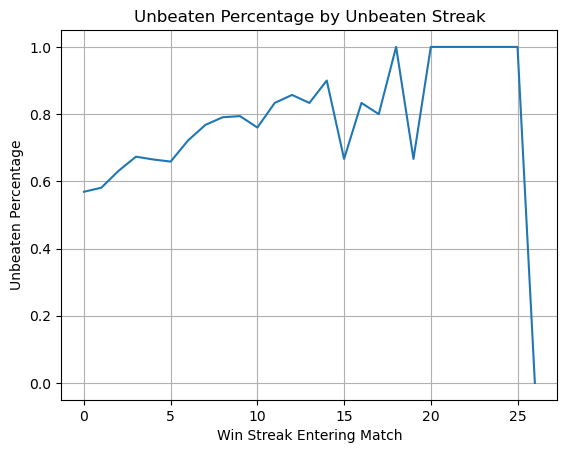

In [55]:
plt.plot(result_by_unbeatenstreak.index, result_by_unbeatenstreak['UnbeatenPercentage'])
plt.xlabel("Win Streak Entering Match")
plt.ylabel("Unbeaten Percentage")
plt.title("Unbeaten Percentage by Unbeaten Streak")
plt.grid(True)
plt.show()

#### Let's require a sample size > 4 like we did in Question 1

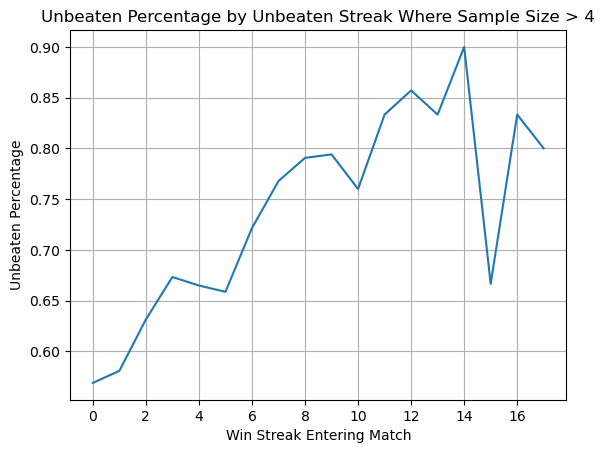

In [56]:
mask = result_by_unbeatenstreak['SampleSize'] > 4
reduced_data = result_by_unbeatenstreak[mask]
plt.plot(reduced_data.index, reduced_data['UnbeatenPercentage'])
plt.xlabel("Win Streak Entering Match")
plt.ylabel("Unbeaten Percentage")
plt.title("Unbeaten Percentage by Unbeaten Streak Where Sample Size > 4")
plt.grid(True)
plt.xticks(range(0, 17, 2)) # Changing What x tick marks count by
plt.show()

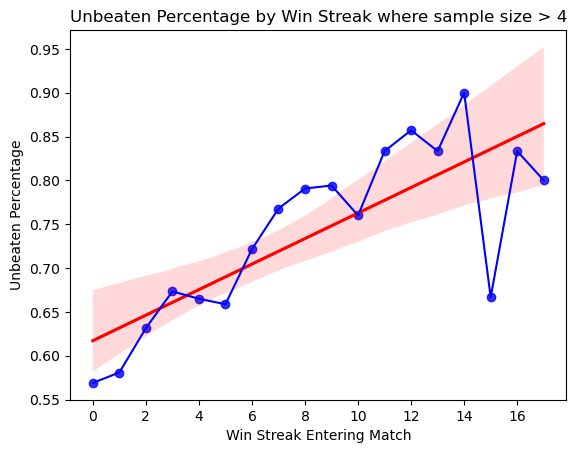

In [57]:
mask = result_by_unbeatenstreak['SampleSize'] > 4
reduced_data = result_by_unbeatenstreak[mask]
sns.regplot(x=reduced_data.index, y=reduced_data['UnbeatenPercentage'], color='blue', line_kws={"color": "red"})
plt.plot(reduced_data.index, reduced_data['UnbeatenPercentage'], color='blue')
plt.xlabel("Win Streak Entering Match")
plt.ylabel("Unbeaten Percentage")
plt.title("Unbeaten Percentage by Win Streak where sample size > 4")
plt.xticks(range(0, 17, 2))
plt.show()

In [58]:
# Calculating the slope, intercept, and r-value of the linear regression line
x = reduced_data.index.values
y = reduced_data['UnbeatenPercentage'].values

reg_line = linregress(x, y)

print('Slope:', reg_line.slope)
print('Intercept:', reg_line.intercept)
print('R-value:', reg_line.rvalue)

Slope: 0.014559607145613331
Intercept: 0.617151380689643
R-value: 0.7902481110590761


We see a positve correlation netween unbeaten streak and unbeaten percentage. Although, this is not as strong as the correlation between win streak and win percentage.

### b) Let's look at all results based on unbeaten streak

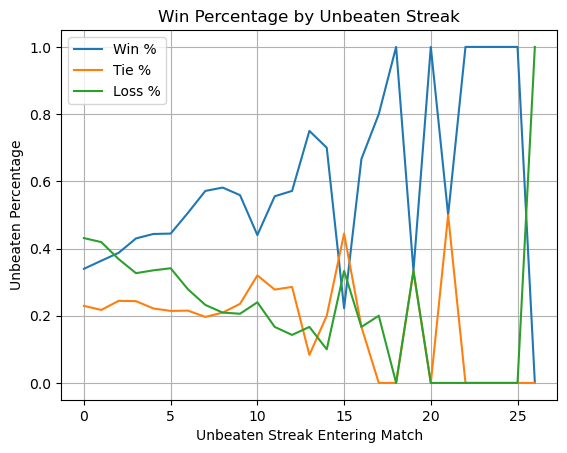

In [59]:
plt.plot(result_by_unbeatenstreak.index, result_by_unbeatenstreak['WinPercentage'], label = 'Win %')
plt.plot(result_by_unbeatenstreak.index, result_by_unbeatenstreak['TiePercentage'], label = 'Tie %')
plt.plot(result_by_unbeatenstreak.index, result_by_unbeatenstreak['LossPercentage'], label = 'Loss %')
plt.xlabel("Unbeaten Streak Entering Match")
plt.ylabel("Unbeaten Percentage")
plt.title("Win Percentage by Unbeaten Streak")
plt.grid(True)
plt.legend()
plt.show()

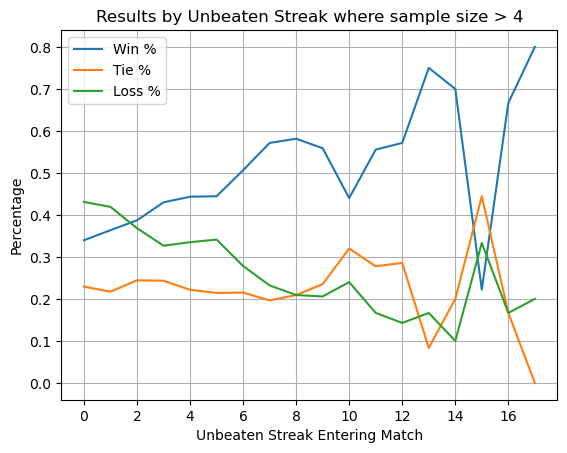

In [60]:
mask = result_by_unbeatenstreak['SampleSize'] >= 5
reduced_data = result_by_unbeatenstreak[mask]
plt.plot(reduced_data.index, reduced_data['WinPercentage'], label = 'Win %')
plt.plot(reduced_data.index, reduced_data['TiePercentage'], label = 'Tie %')
plt.plot(reduced_data.index, reduced_data['LossPercentage'], label = 'Loss %')
plt.xlabel("Unbeaten Streak Entering Match")
plt.ylabel("Percentage")
plt.title("Results by Unbeaten Streak where sample size > 4")
plt.grid(True)
plt.legend()
plt.xticks(range(0, 18, 2))
plt.show()

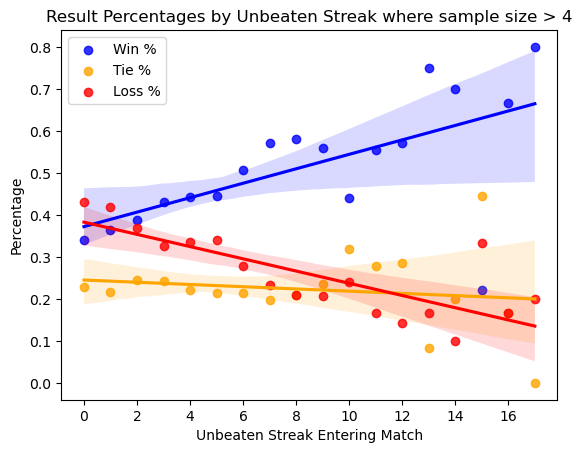

In [61]:
mask = result_by_unbeatenstreak['SampleSize'] > 4
reduced_data = result_by_unbeatenstreak[mask]
sns.regplot(x=reduced_data.index, y=reduced_data['WinPercentage'], color='blue', line_kws={'color': 'blue'}, label = 'Win %')
sns.regplot(x=reduced_data.index, y=reduced_data['TiePercentage'], color='orange', line_kws={'color': 'orange'}, label = 'Tie %')
sns.regplot(x=reduced_data.index, y=reduced_data['LossPercentage'], color='red', line_kws={'color': 'red'}, label = 'Loss %')
plt.xlabel("Unbeaten Streak Entering Match")
plt.ylabel("Percentage")
plt.title("Result Percentages by Unbeaten Streak where sample size > 4")
plt.xticks(range(0, 18, 2))
plt.legend()
plt.show()

In [62]:
# Calculating the slopem intercept, and r-value of the linear regression lines
x = reduced_data.index.values
reg_data = {'Win': reduced_data['WinPercentage'].values, 'Tie': reduced_data['TiePercentage'].values, 'Loss': reduced_data['LossPercentage'].values}
for name, y in reg_data.items():
    reg_line = linregress(x, y)
    print(name, "Slope:", reg_line.slope)
    print(name, "Intercept:", reg_line.intercept)
    print(name, "R-value:", reg_line.rvalue)

Win Slope: 0.01720851532369062
Win Intercept: 0.372176372148461
Win R-value: 0.609232849825027
Tie Slope: -0.0026489081780772922
Tie Intercept: 0.2449750085411821
Tie R-value: -0.15558678058044428
Loss Slope: -0.014559607145613331
Loss Intercept: 0.38284861931035696
Loss R-value: -0.790248111059076


We see a strong negative correlation between unbeaten streak and loss %, but unbeaten streak and win % and unbeaten streak and tie % have week correlations.

## 3. Is win streak or unbeaten streak a better predictor?

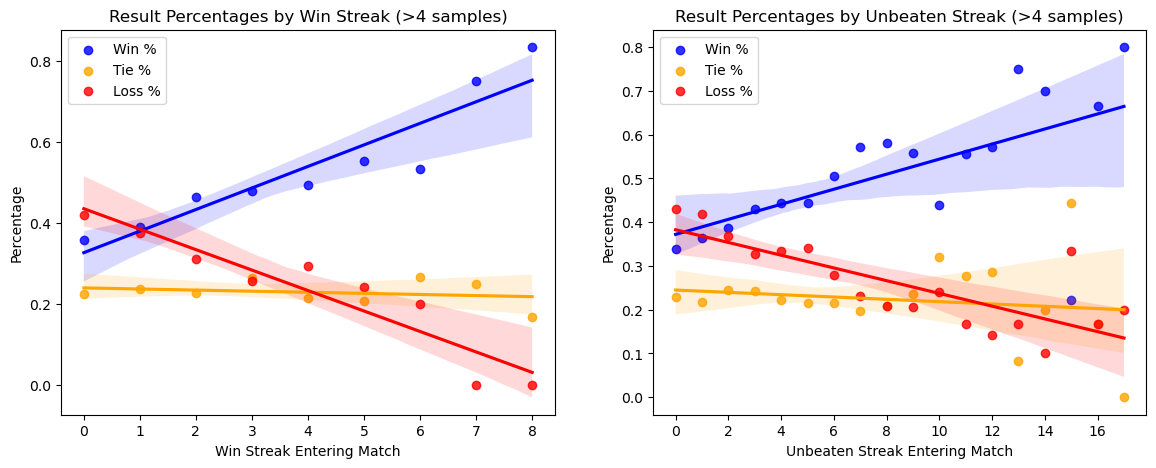

In [63]:
# Plotting regression line plots from Q1 and Q2 beside each other
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

mask1 = result_by_winstreak['SampleSize'] > 4
reduced_data1 = result_by_winstreak[mask1]

sns.regplot(x=reduced_data1.index, y=reduced_data1['WinPercentage'], color='blue', line_kws={'color': 'blue'}, label='Win %', ax=axes[0])
sns.regplot(x=reduced_data1.index, y=reduced_data1['TiePercentage'], color='orange', line_kws={'color': 'orange'}, label='Tie %', ax=axes[0])
sns.regplot(x=reduced_data1.index, y=reduced_data1['LossPercentage'], color='red', line_kws={'color': 'red'}, label='Loss %', ax=axes[0])
axes[0].set_xlabel("Win Streak Entering Match")
axes[0].set_ylabel("Percentage")
axes[0].set_title("Result Percentages by Win Streak (>4 samples)")
axes[0].legend()

mask2 = result_by_unbeatenstreak['SampleSize'] > 4
reduced_data2 = result_by_unbeatenstreak[mask2]

sns.regplot(x=reduced_data2.index, y=reduced_data2['WinPercentage'], color='blue', line_kws={'color': 'blue'}, label='Win %', ax=axes[1])
sns.regplot(x=reduced_data2.index, y=reduced_data2['TiePercentage'], color='orange', line_kws={'color': 'orange'}, label='Tie %', ax=axes[1])
sns.regplot(x=reduced_data2.index, y=reduced_data2['LossPercentage'], color='red', line_kws={'color': 'red'}, label='Loss %', ax=axes[1])

axes[1].set_xlabel("Unbeaten Streak Entering Match")
axes[1].set_ylabel("Percentage")
axes[1].set_title("Result Percentages by Unbeaten Streak (>4 samples)")
axes[1].set_xticks(range(0, 18, 2))
axes[1].legend()

plt.show()

We can see based on the graphs that Win Streak seems to be a better predictor than Unbeaten Streak. The data points on the win streak graph are generally closer to the regression line than the unbeaten streak data points.

In [64]:
print('Result Percentages by Win Streak (>4 samples):')
x1 = reduced_data1.index.values
reg_data = {'Win': reduced_data1['WinPercentage'].values, 'Tie': reduced_data1['TiePercentage'].values, 'Loss': reduced_data1['LossPercentage'].values}
for name, y1 in reg_data.items():
    reg_line = linregress(x1, y1)
    print(name, "Slope:", reg_line.slope)
    print(name, "Intercept:", reg_line.intercept)
    print(name, "R-value:", reg_line.rvalue)


print('\n\n\nResult Percentages by Unbeaten Streak (>4 samples):')
x2 = reduced_data2.index.values
reg_data = {'Win': reduced_data2['WinPercentage'].values, 'Tie': reduced_data2['TiePercentage'].values, 'Loss': reduced_data2['LossPercentage'].values}
for name, y2 in reg_data.items():
    reg_line = linregress(x2, y2)
    print(name, "Slope:", reg_line.slope)
    print(name, "Intercept:", reg_line.intercept)
    print(name, "R-value:", reg_line.rvalue)

Result Percentages by Win Streak (>4 samples):
Win Slope: 0.05321681034153181
Win Intercept: 0.3261543207723514
Win R-value: 0.9270352434119623
Tie Slope: -0.0027018432589045113
Tie Intercept: 0.23916592753630095
Tie R-value: -0.23783340027895108
Loss Slope: -0.05051496708262731
Loss Intercept: 0.43467975169134765
Loss R-value: -0.9381973056484305



Result Percentages by Unbeaten Streak (>4 samples):
Win Slope: 0.01720851532369062
Win Intercept: 0.372176372148461
Win R-value: 0.609232849825027
Tie Slope: -0.0026489081780772922
Tie Intercept: 0.2449750085411821
Tie R-value: -0.15558678058044428
Loss Slope: -0.014559607145613331
Loss Intercept: 0.38284861931035696
Loss R-value: -0.790248111059076


We can also see that the R-values for the regression lines of the win streak predictor are much higher than the R-values for the regression lines of the unbeaten streak predictors. This means there is a stronger correlation between win streak and match outcome.

## 4. Does Points earned in the last n matches predict points earned in the next match?

# SHOULD WE USE DIFFERENT VALUES OF N TO SEE IF WE CAN GET AN EVEN BETTER RESULTS
# NEW QUESTION LOOKING AT WHAT VALUES OF N IS THE BEST PREDICTOR

Using n = 3 and n = 5

### a) Does Points earned in the last 3 matches predict points earned in the next match?

In [65]:
# Creating dataframe of last3points and points earned in next match to do analysis
last3points = df.groupby('Last3Points')
last3points_counts = last3points.size()
result_by_last3points = last3points_counts.to_frame() # Transforming series of unbeaten streak counts to dataframe
result_by_last3points.columns = ['SampleSize'] # Naming column
result_by_last3points['PointsEarned'] = (df.groupby('Last3Points')['Points']).mean()
result_by_last3points

,SampleSize,PointsEarned
Last3Points,,
0,417,1.151079
1,443,1.137698
2,223,1.264574
3,656,1.257622
4,650,1.361538
5,216,1.587963
6,502,1.486056
7,413,1.680387
9,280,1.814286


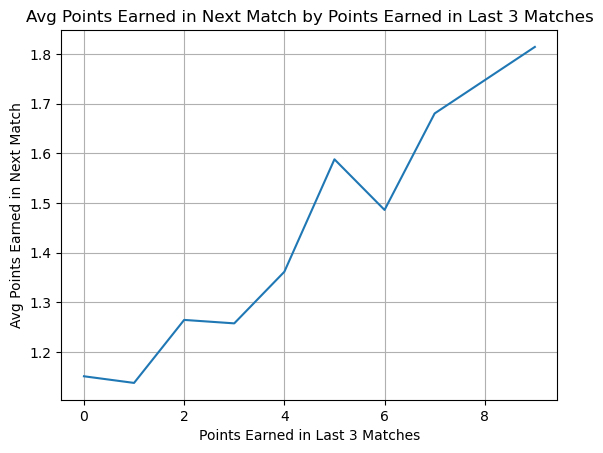

In [66]:
plt.plot(result_by_last3points.index, result_by_last3points['PointsEarned'])
plt.xlabel("Points Earned in Last 3 Matches")
plt.ylabel("Avg Points Earned in Next Match")
plt.title("Avg Points Earned in Next Match by Points Earned in Last 3 Matches")
plt.grid(True)
plt.show()

We can see a positive correlation between points earned in last 3 matches and average points earned in next match. 

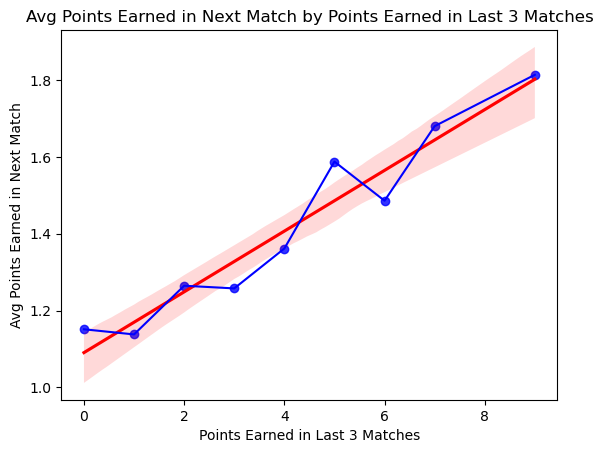

In [67]:
sns.regplot(x=result_by_last3points.index, y=result_by_last3points['PointsEarned'], color='blue', line_kws={"color": "red"})
plt.plot(result_by_last3points.index, result_by_last3points['PointsEarned'], color='blue')
plt.title("Avg Points Earned in Next Match by Points Earned in Last 3 Matches")
plt.xlabel("Points Earned in Last 3 Matches")
plt.ylabel("Avg Points Earned in Next Match")
plt.show()

In [68]:
# Calculating the slope, intercept, and r-value of the linear regression line
x = result_by_last3points.index.values
y = result_by_last3points['PointsEarned'].values

reg_line = linregress(x, y)

print('Slope:', reg_line.slope)
print('Intercept:', reg_line.intercept)
print('R-value:', reg_line.rvalue)

Slope: 0.07915350587701134
Intercept: 1.0902803559225214
R-value: 0.9669409790531964


We see a very strong positive correlation between points earned in last 3 matches and average points earned in next match.

### b) Does Points earned in the last 5 matches predict points earned in the next match?

In [69]:
# Creating dataframe of last5points and points earned in next match to do analysis
last5points = df.groupby('Last5Points')
last5points_counts = last5points.size()
result_by_last5points = last5points_counts.to_frame() # Transforming series of unbeaten streak counts to dataframe
result_by_last5points.columns = ['SampleSize'] # Naming column
result_by_last5points['PointsEarned'] = (df.groupby('Last5Points')['Points']).mean()
result_by_last5points

,SampleSize,PointsEarned
Last5Points,,
0,236,1.169492
1,200,0.950000
2,136,1.191176
3,337,1.172107
4,397,1.219144
5,276,1.333333
6,380,1.357895
7,446,1.385650
8,272,1.426471


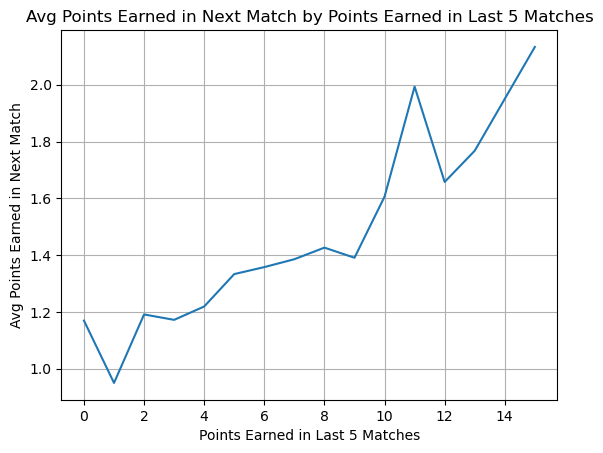

In [70]:
plt.plot(result_by_last5points.index, result_by_last5points['PointsEarned'])
plt.xlabel("Points Earned in Last 5 Matches")
plt.ylabel("Avg Points Earned in Next Match")
plt.title("Avg Points Earned in Next Match by Points Earned in Last 5 Matches")
plt.grid(True)
plt.show()

We see a positive correlation between points earned in last 5 matches and avg points earned in next match.

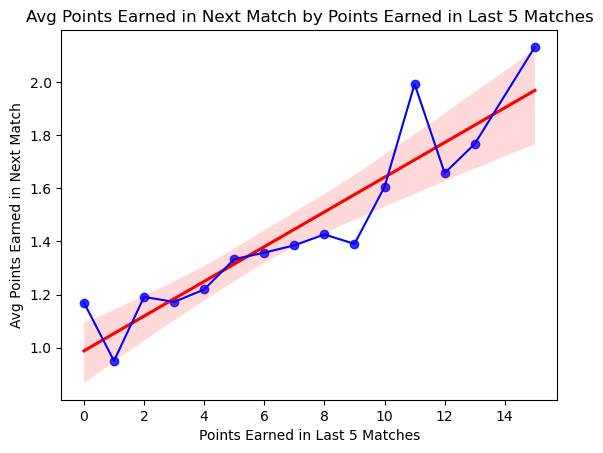

In [71]:
sns.regplot(x=result_by_last5points.index, y=result_by_last5points['PointsEarned'], color='blue', line_kws={"color": "red"})
plt.plot(result_by_last5points.index, result_by_last5points['PointsEarned'], color='blue')
plt.title("Avg Points Earned in Next Match by Points Earned in Last 5 Matches")
plt.xlabel("Points Earned in Last 5 Matches")
plt.ylabel("Avg Points Earned in Next Match")
plt.show()

In [72]:
# Calculating the slope, intercept, and r-value of the linear regression line
x = result_by_last5points.index.values
y = result_by_last5points['PointsEarned'].values

reg_line = linregress(x, y)

print('Slope:', reg_line.slope)
print('Intercept:', reg_line.intercept)
print('R-value:', reg_line.rvalue)

Slope: 0.0654348119292703
Intercept: 0.9878882885286566
R-value: 0.9214492284639357


We see a strong positive correlation betwen points earned in last 5 matches and average points earned in next match. Looking at the graph we see that this correlation is the strongest when the points earned in the last 5 matches was between around 3 and 7. Before and after this the correlation is weaker.

### c) Is points earned in last 3 matches or points earned in last 5 matches a better predictor of points earend in next match?

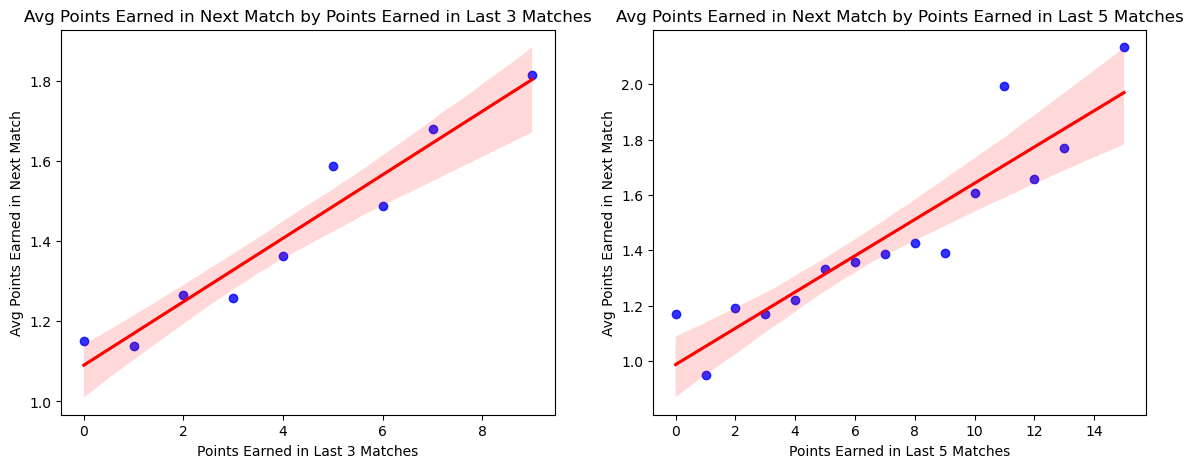

In [73]:
# Plotting regression line plots from Q4a and Q4b beside each other
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.regplot(x=result_by_last3points.index, y=result_by_last3points['PointsEarned'], color='blue', line_kws={"color": "red"}, ax=axes[0])
axes[0].set_title("Avg Points Earned in Next Match by Points Earned in Last 3 Matches")
axes[0].set_xlabel("Points Earned in Last 3 Matches")
axes[0].set_ylabel("Avg Points Earned in Next Match")

sns.regplot(x=result_by_last5points.index, y=result_by_last5points['PointsEarned'], color='blue', line_kws={"color": "red"}, ax=axes[1])
axes[1].set_title("Avg Points Earned in Next Match by Points Earned in Last 5 Matches")
axes[1].set_xlabel("Points Earned in Last 5 Matches")
axes[1].set_ylabel("Avg Points Earned in Next Match")

plt.show()

In [74]:
# Calculating the slope, intercept, and r-value of the linear regression lines
print('Avg Points Earned in Next Match by Points Earned in Last 3 Matches:')
x1 = result_by_last3points.index.values
y1 = result_by_last3points['PointsEarned'].values

reg_line1 = linregress(x1, y1)

print('Slope:', reg_line1.slope)
print('Intercept:', reg_line1.intercept)
print('R-value:', reg_line1.rvalue)

print('\n\nAvg Points Earned in Next Match by Points Earned in Last 5 Matches:')
x2 = result_by_last5points.index.values
y2 = result_by_last5points['PointsEarned'].values

reg_line2 = linregress(x2, y2)

print('Slope:', reg_line2.slope)
print('Intercept:', reg_line2.intercept)
print('R-value:', reg_line2.rvalue)


Avg Points Earned in Next Match by Points Earned in Last 3 Matches:
Slope: 0.07915350587701134
Intercept: 1.0902803559225214
R-value: 0.9669409790531964


Avg Points Earned in Next Match by Points Earned in Last 5 Matches:
Slope: 0.0654348119292703
Intercept: 0.9878882885286566
R-value: 0.9214492284639357


We see that points earned in last 3 matches has a stronger and greater correlation. We can thus conclude that points earned in last 3 matches is a better predictor of points earned in next match than points earned in last 5 matches. A logical explanation of this is that if we look at the last 5 matches we have more data, but the last 3 matches is a better predictor of current momentum because the 4th and the 5th matches aren't weren't recent enough.

## 5. Does a team’s recent goal differential correlate with goal differential in the next match?

Using n = 3 and n = 5

### a) Does Goal Differential in the last 3 matches predict goal differential in the next match?

In [75]:
# Creating dataframe of last3GD and GD in next match to do analysis
last3GD = df.groupby('Last3GD')
last3GD_counts = last3GD.size()
result_by_last3GD = last3GD_counts.to_frame() # Transforming series of last3GD counts to dataframe
result_by_last3GD.columns = ['SampleSize'] # Naming column
result_by_last3GD['GoalDifferential'] = (df.groupby('Last3GD')['GoalDifferential']).mean()
result_by_last3GD

,SampleSize,GoalDifferential
Last3GD,,
-16,1,0.000000
-12,5,-0.400000
-11,8,-0.875000
-10,13,-0.461538
-9,15,-0.733333
-8,38,-0.631579
-7,50,-0.680000
-6,82,-0.451220
-5,157,-0.566879


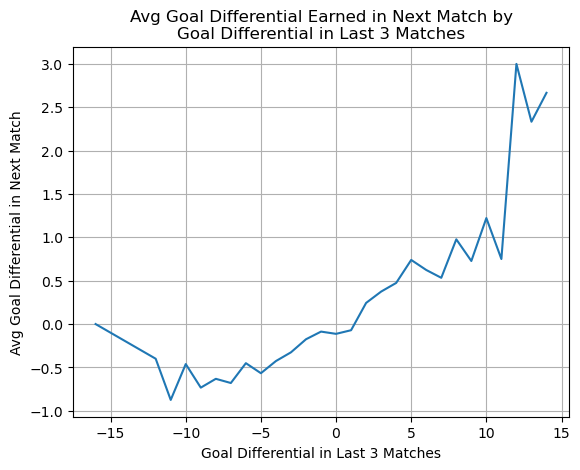

In [76]:
plt.plot(result_by_last3GD.index, result_by_last3GD['GoalDifferential'])
plt.xlabel("Goal Differential in Last 3 Matches")
plt.ylabel("Avg Goal Differential in Next Match")
plt.title("Avg Goal Differential Earned in Next Match by\nGoal Differential in Last 3 Matches")
plt.grid(True)
plt.show()

#### Requiring a minimum sample size of 5 like we did in Q1.

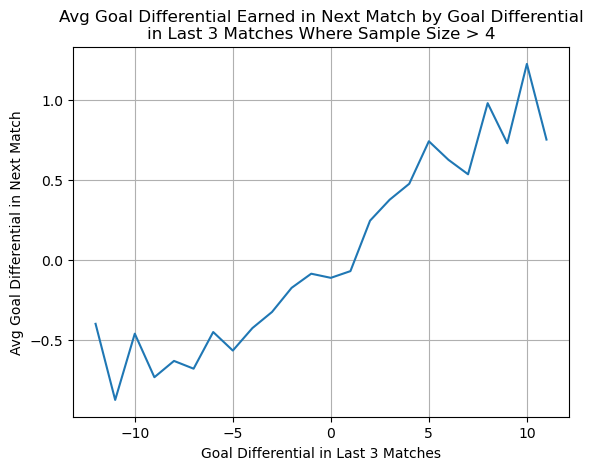

In [77]:
mask = result_by_last3GD['SampleSize'] >= 5
reduced_data = result_by_last3GD[mask]
plt.plot(reduced_data.index, reduced_data['GoalDifferential'])
plt.xlabel("Goal Differential in Last 3 Matches")
plt.ylabel("Avg Goal Differential in Next Match")
plt.title("Avg Goal Differential Earned in Next Match by Goal Differential\nin Last 3 Matches Where Sample Size > 4")
plt.grid(True)
plt.show()

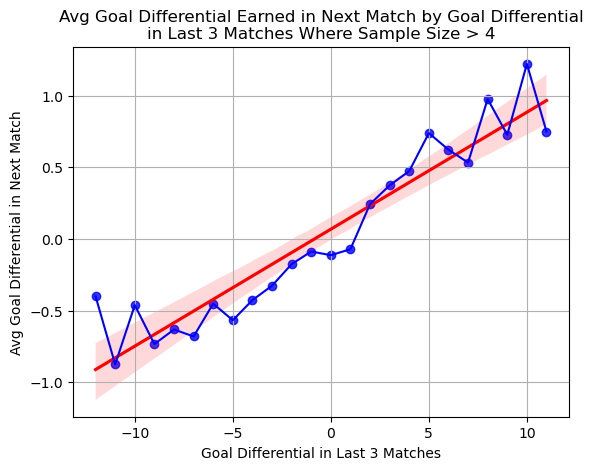

In [78]:
# Plotting with regression line
mask = result_by_last3GD['SampleSize'] >= 5
reduced_data = result_by_last3GD[mask]
sns.regplot(x=reduced_data.index, y=reduced_data['GoalDifferential'], color='blue', line_kws={"color": "red"})
plt.plot(reduced_data.index, reduced_data['GoalDifferential'], color='blue')
plt.xlabel("Goal Differential in Last 3 Matches")
plt.ylabel("Avg Goal Differential in Next Match")
plt.title("Avg Goal Differential Earned in Next Match by Goal Differential\nin Last 3 Matches Where Sample Size > 4")
plt.grid(True)
plt.show()

In [79]:
# Calculating the slope, intercept, and r-value of the linear regression line
x = result_by_last3GD.index.values
y = result_by_last3GD['GoalDifferential'].values

reg_line = linregress(x, y)

print('Slope:', reg_line.slope)
print('Intercept:', reg_line.intercept)
print('R-value:', reg_line.rvalue)

Slope: 0.10112493142708733
Intercept: 0.26980532820074343
R-value: 0.8447793202975822


We see positive relatively strong correlation between goal differential in last 3 matches and average goal differential in next match. This correlation is less positive and strong than the correlations found between winning streak and match outcome and points earned in last n matches (where n is 3 or 5) and points earned in next match.

### b) Does Goal Differential in the last 5 matches predict goal differential in the next match?

In [80]:
# Creating dataframe of last5GD and GD in next match to do analysis
last5GD = df.groupby('Last5GD')
last5GD_counts = last5GD.size()
result_by_last5GD = last5GD_counts.to_frame() # Transforming series of last5GD counts to dataframe
result_by_last5GD.columns = ['SampleSize'] # Naming column
result_by_last5GD['GoalDifferential'] = (df.groupby('Last5GD')['GoalDifferential']).mean()
result_by_last5GD

,SampleSize,GoalDifferential
Last5GD,,
-18,1,1.000000
-16,2,-1.000000
-15,4,-0.500000
-14,8,-0.875000
-13,10,-0.600000
-12,23,-1.347826
-11,24,-0.791667
-10,26,-0.500000
-9,67,-0.761194


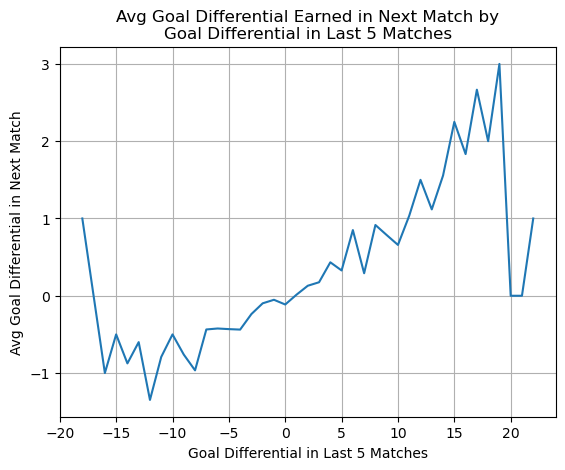

In [81]:
plt.plot(result_by_last5GD.index, result_by_last5GD['GoalDifferential'])
plt.xlabel("Goal Differential in Last 5 Matches")
plt.ylabel("Avg Goal Differential in Next Match")
plt.title("Avg Goal Differential Earned in Next Match by\nGoal Differential in Last 5 Matches")
plt.grid(True)
plt.show()

#### Requiring minimum sample size of 5 again.

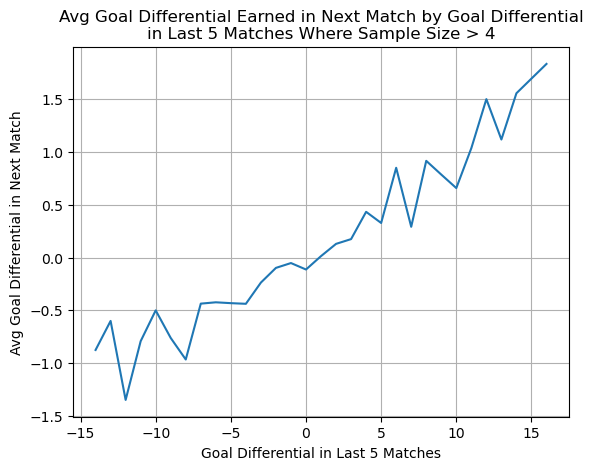

In [82]:
mask = result_by_last5GD['SampleSize'] >= 5
reduced_data = result_by_last5GD[mask]
plt.plot(reduced_data.index, reduced_data['GoalDifferential'])
plt.xlabel("Goal Differential in Last 5 Matches")
plt.ylabel("Avg Goal Differential in Next Match")
plt.title("Avg Goal Differential Earned in Next Match by Goal Differential\nin Last 5 Matches Where Sample Size > 4")
plt.grid(True)
plt.show()

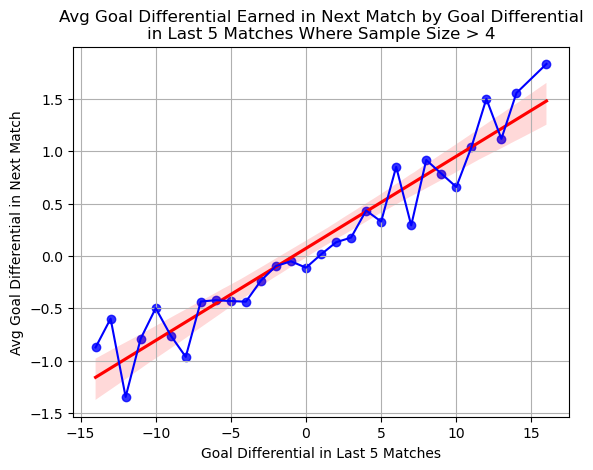

In [83]:
# Plotting with regression line
mask = result_by_last5GD['SampleSize'] >= 5
reduced_data = result_by_last5GD[mask]
sns.regplot(x=reduced_data.index, y=reduced_data['GoalDifferential'], color='blue', line_kws={"color": "red"})
plt.plot(reduced_data.index, reduced_data['GoalDifferential'], color='blue')
plt.xlabel("Goal Differential in Last 5 Matches")
plt.ylabel("Avg Goal Differential in Next Match")
plt.title("Avg Goal Differential Earned in Next Match by Goal Differential\nin Last 5 Matches Where Sample Size > 4")
plt.grid(True)
plt.show()

In [84]:
# Calculating the slope, intercept, and r-value of the linear regression line (of data where sample size > 4)
x = reduced_data.index.values
y = reduced_data['GoalDifferential'].values

reg_line = linregress(x, y)

print('Slope:', reg_line.slope)
print('Intercept:', reg_line.intercept)
print('R-value:', reg_line.rvalue)

Slope: 0.08798639610375465
Intercept: 0.07146868906868559
R-value: 0.960052859361458


We see a very strong positive correlation between goal differential in the last 5 matches and average goal differential in the next match. Looking at the graph, there is a very strong correlation when the goal differential in the last 5 matches was beteen -5 and 4.

### c) Is goal differential in last 3 matches or goal differential in last 5 matches a better predictor of goal differential in next match?

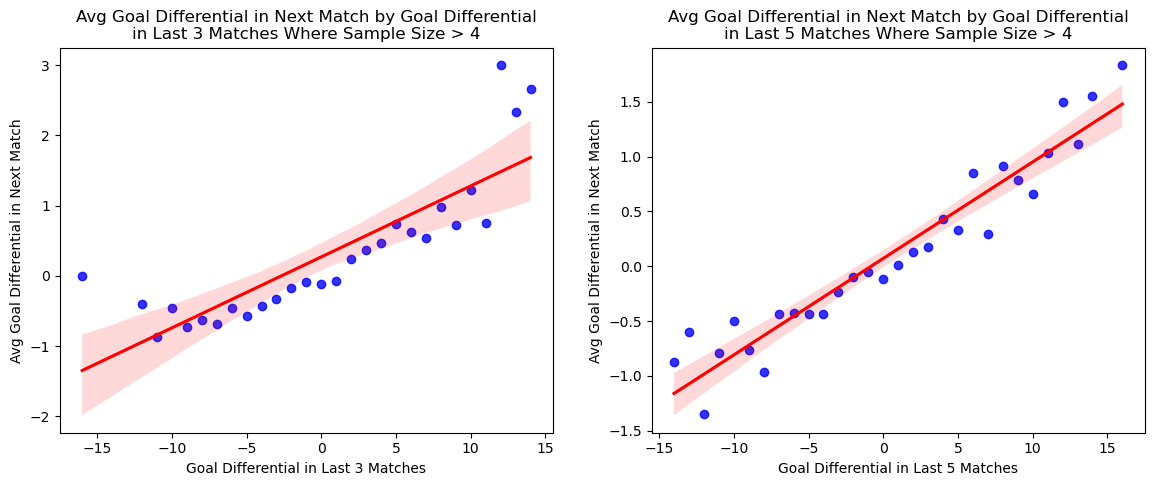

In [85]:
# Plotting regression line plots from Q5a and Q5b beside each other
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

mask1 = result_by_last3GD['SampleSize'] > 4
reduced_data1 = result_by_last3GD[mask1]

sns.regplot(x=result_by_last3GD.index, y=result_by_last3GD['GoalDifferential'], color='blue', line_kws={"color": "red"}, ax=axes[0])
axes[0].set_title("Avg Goal Differential in Next Match by Goal Differential\nin Last 3 Matches Where Sample Size > 4")
axes[0].set_xlabel("Goal Differential in Last 3 Matches")
axes[0].set_ylabel("Avg Goal Differential in Next Match")

mask2 = result_by_last5GD['SampleSize'] > 4
reduced_data2 = result_by_last5GD[mask2]

sns.regplot(x=reduced_data2.index, y=reduced_data2['GoalDifferential'], color='blue', line_kws={"color": "red"}, ax=axes[1])
axes[1].set_title("Avg Goal Differential in Next Match by Goal Differential\nin Last 5 Matches Where Sample Size > 4")
axes[1].set_xlabel("Goal Differential in Last 5 Matches")
axes[1].set_ylabel("Avg Goal Differential in Next Match")

plt.show()

In [86]:
# Calculating the slope, intercept, and r-value of the linear regression lines
print('Avg Goal Differential in Next Match by Goal Differential in Last 3 Matches Where Sample Size > 4:')
x1 = reduced_data1.index.values
y1 = reduced_data1['GoalDifferential'].values

reg_line1 = linregress(x1, y1)

print('Slope:', reg_line1.slope)
print('Intercept:', reg_line1.intercept)
print('R-value:', reg_line1.rvalue)

print('\n\nAvg Goal Differential in Next Match by Goal Differential in Last 5 Matches Where Sample Size > 4:')
x2 = reduced_data2.index.values
y2 = reduced_data2['GoalDifferential'].values

reg_line2 = linregress(x2, y2)

print('Slope:', reg_line2.slope)
print('Intercept:', reg_line2.intercept)
print('R-value:', reg_line2.rvalue)


Avg Goal Differential in Next Match by Goal Differential in Last 3 Matches Where Sample Size > 4:
Slope: 0.08164838863707448
Intercept: 0.06861267079015293
R-value: 0.9456170265953291


Avg Goal Differential in Next Match by Goal Differential in Last 5 Matches Where Sample Size > 4:
Slope: 0.08798639610375465
Intercept: 0.07146868906868559
R-value: 0.960052859361458


Goal differential in the last 5 matches has a slightly stronger and more positive correlation with goal differential in the next match than goal differential in the last 3 matches has with goal differential in the next match. Although the strenght of these correlations are very close (as we see by the r-values).

## 6. Does a team’s recent goal differential correlate with match outcome?

In [87]:
# Using result_by_last3GD and result_by_last5GD dataframes that were created in Q5
# Adding win, tie, and loss percentages to these dataframes
# Creating dataframe of results by winstreak to do analysis
result_by_last3GD['WinPercentage'] = (df.groupby('Last3GD')['Result'].apply(lambda x: (x == 'W').mean())) # Calculating WinPercentage by Last3GD
result_by_last3GD['TiePercentage'] = (df.groupby('Last3GD')['Result'].apply(lambda x: (x == 'T').mean())) # Calculating TiePercentage by Last3GD
result_by_last3GD['LossPercentage'] = (df.groupby('Last3GD')['Result'].apply(lambda x: (x == 'L').mean())) # Calculating LossPercentage by Last3GD

result_by_last5GD['WinPercentage'] = (df.groupby('Last5GD')['Result'].apply(lambda x: (x == 'W').mean())) # Calculating WinPercentage by Last5GD
result_by_last5GD['TiePercentage'] = (df.groupby('Last5GD')['Result'].apply(lambda x: (x == 'T').mean())) # Calculating TiePercentage by Last5GD
result_by_last5GD['LossPercentage'] = (df.groupby('Last5GD')['Result'].apply(lambda x: (x == 'L').mean())) # Calculating LossPercentage by Last5GD

In [88]:
result_by_last3GD

,SampleSize,GoalDifferential,WinPercentage,TiePercentage,LossPercentage
Last3GD,,,,,
-16,1,0.000000,0.000000,1.000000,0.000000
-12,5,-0.400000,0.200000,0.200000,0.600000
-11,8,-0.875000,0.250000,0.125000,0.625000
-10,13,-0.461538,0.153846,0.461538,0.384615
-9,15,-0.733333,0.266667,0.133333,0.600000
-8,38,-0.631579,0.289474,0.131579,0.578947
-7,50,-0.680000,0.240000,0.220000,0.540000
-6,82,-0.451220,0.256098,0.268293,0.475610
-5,157,-0.566879,0.286624,0.235669,0.477707


In [89]:
result_by_last5GD

,SampleSize,GoalDifferential,WinPercentage,TiePercentage,LossPercentage
Last5GD,,,,,
-18,1,1.000000,1.000000,0.000000,0.000000
-16,2,-1.000000,0.500000,0.000000,0.500000
-15,4,-0.500000,0.000000,0.500000,0.500000
-14,8,-0.875000,0.125000,0.500000,0.375000
-13,10,-0.600000,0.200000,0.200000,0.600000
-12,23,-1.347826,0.217391,0.130435,0.652174
-11,24,-0.791667,0.125000,0.208333,0.666667
-10,26,-0.500000,0.307692,0.230769,0.461538
-9,67,-0.761194,0.223881,0.194030,0.582090


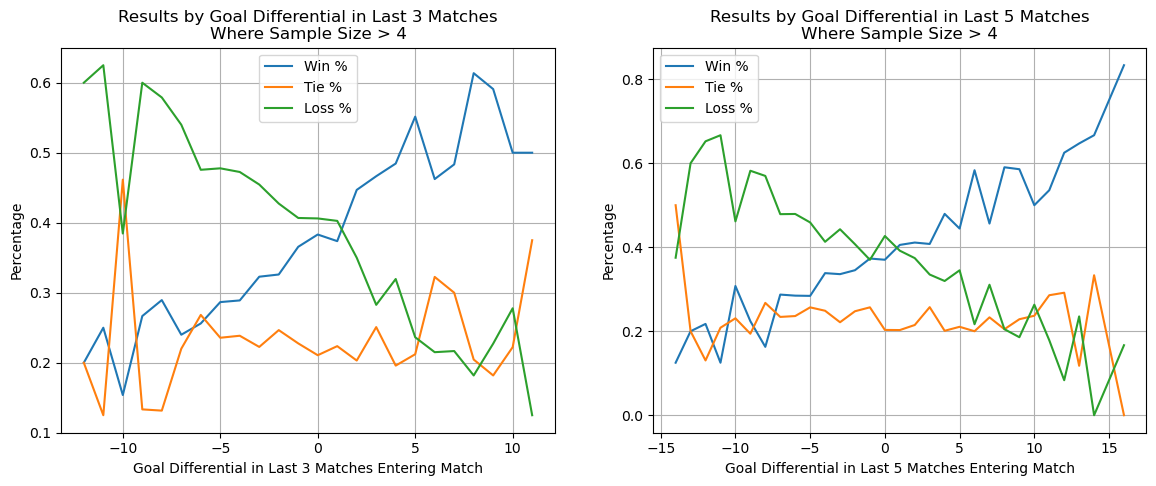

In [90]:
# Plotting graph for results by goal differential in last n matches where n = 3 and 5 (where sample size still has to to be > 4)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

mask1 = result_by_last3GD['SampleSize'] >= 5
reduced_data1 = result_by_last3GD[mask1]

axes[0].plot(reduced_data1.index, reduced_data1['WinPercentage'], label='Win %')
axes[0].plot(reduced_data1.index, reduced_data1['TiePercentage'], label='Tie %')
axes[0].plot(reduced_data1.index, reduced_data1['LossPercentage'], label='Loss %')

axes[0].set_xlabel("Goal Differential in Last 3 Matches Entering Match")
axes[0].set_ylabel("Percentage")
axes[0].set_title("Results by Goal Differential in Last 3 Matches\nWhere Sample Size > 4")
axes[0].grid(True)
axes[0].legend()

mask2 = result_by_last5GD['SampleSize'] >= 5
reduced_data2 = result_by_last5GD[mask2]

axes[1].plot(reduced_data2.index, reduced_data2['WinPercentage'], label='Win %')
axes[1].plot(reduced_data2.index, reduced_data2['TiePercentage'], label='Tie %')
axes[1].plot(reduced_data2.index, reduced_data2['LossPercentage'], label='Loss %')

axes[1].set_xlabel("Goal Differential in Last 5 Matches Entering Match")
axes[1].set_ylabel("Percentage")
axes[1].set_title("Results by Goal Differential in Last 5 Matches\nWhere Sample Size > 4")
axes[1].grid(True)
axes[1].legend()

plt.show()

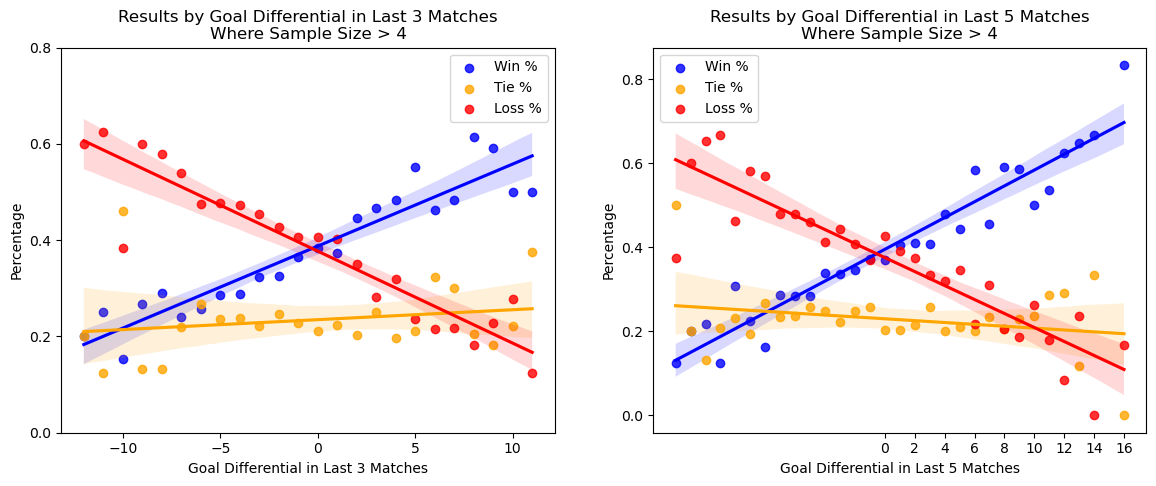

In [91]:
# Plotting regression line plots from Q1 and Q2 beside each other
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

mask1 = result_by_last3GD['SampleSize'] > 4
reduced_data1 = result_by_last3GD[mask1]

sns.regplot(x=reduced_data1.index, y=reduced_data1['WinPercentage'], color='blue', line_kws={'color': 'blue'}, label='Win %', ax=axes[0])
sns.regplot(x=reduced_data1.index, y=reduced_data1['TiePercentage'], color='orange', line_kws={'color': 'orange'}, label='Tie %', ax=axes[0])
sns.regplot(x=reduced_data1.index, y=reduced_data1['LossPercentage'], color='red', line_kws={'color': 'red'}, label='Loss %', ax=axes[0])
axes[0].set_xlabel("Goal Differential in Last 3 Matches")
axes[0].set_ylabel("Percentage")
axes[0].set_title("Results by Goal Differential in Last 3 Matches\nWhere Sample Size > 4")
axes[0].set_yticks([i/10 for i in range(0,9,2)])
axes[0].legend()

mask2 = result_by_last5GD['SampleSize'] > 4
reduced_data2 = result_by_last5GD[mask2]

sns.regplot(x=reduced_data2.index, y=reduced_data2['WinPercentage'], color='blue', line_kws={'color': 'blue'}, label='Win %', ax=axes[1])
sns.regplot(x=reduced_data2.index, y=reduced_data2['TiePercentage'], color='orange', line_kws={'color': 'orange'}, label='Tie %', ax=axes[1])
sns.regplot(x=reduced_data2.index, y=reduced_data2['LossPercentage'], color='red', line_kws={'color': 'red'}, label='Loss %', ax=axes[1])

axes[1].set_xlabel("Goal Differential in Last 5 Matches")
axes[1].set_ylabel("Percentage")
axes[1].set_title("Results by Goal Differential in Last 5 Matches\nWhere Sample Size > 4")
axes[1].set_xticks(range(0, 18, 2))
axes[1].legend()

plt.show()

In [92]:
# Calculating the slop, intercept, and r-value of the regression lines
print('Result Percentages by Goal Differential in Last 3 Matches Where Sample Size > 4:')
x1 = reduced_data1.index.values
reg_data1 = {'Win': reduced_data1['WinPercentage'].values, 'Tie': reduced_data1['TiePercentage'].values, 'Loss': reduced_data1['LossPercentage'].values}
for name, y1 in reg_data1.items():
    reg_line1 = linregress(x1, y1)
    print(name, "Slope:", reg_line1.slope)
    print(name, "Intercept:", reg_line1.intercept)
    print(name, "R-value:", reg_line1.rvalue)


print('\n\n\nResult Percentages by Goal Differential in Last 5 Matches Where Sample Size > 4:')
x2 = reduced_data2.index.values
reg_data2 = {'Win': reduced_data2['WinPercentage'].values, 'Tie': reduced_data2['TiePercentage'].values, 'Loss': reduced_data2['LossPercentage'].values}
for name, y2 in reg_data2.items():
    reg_line2 = linregress(x2, y2)
    print(name, "Slope:", reg_line2.slope)
    print(name, "Intercept:", reg_line2.intercept)
    print(name, "R-value:", reg_line2.rvalue)

Result Percentages by Goal Differential in Last 3 Matches Where Sample Size > 4:
Win Slope: 0.017045504380726596
Win Intercept: 0.3878000696934044
Win R-value: 0.940836125406208
Tie Slope: 0.0020652677731649327
Tie Intercept: 0.23491920399687852
Tie R-value: 0.19668986081539794
Loss Slope: -0.019110772153891526
Loss Intercept: 0.37728072630971704
Loss R-value: -0.9310919222064816



Result Percentages by Goal Differential in Last 5 Matches Where Sample Size > 4:
Win Slope: 0.018870622952596297
Win Intercept: 0.39501203870730334
Win R-value: 0.9564456325526367
Tie Slope: -0.002222127056844081
Tie Intercept: 0.22964022693304603
Tie R-value: -0.25177949668387734
Loss Slope: -0.016648495895752218
Loss Intercept: 0.3753477343596506
Loss R-value: -0.9015542284290237


There is a strong positive correlation between goal differential in the last n matches (where n is 3 and 5) and win percentage. There is a slightly stronger correlation when n is 5. There is a strong negative correlation between goal differential in last n matches (where n is 3 and 5) and loss percentage. There is a stronger correlation when n is 3. There is not much of a correlation between goal differential in the last n matches (where n is 3 and 5) and tie percentage. It is interesting that there is a stronger correlation with win percentage when n is 5 but a stronger correlation with loss percentage when n is 3. A logical explanation for this is that positive momentum takes longer to build, but negative momentum takes less time to build. Additionally, we can conclude that there is not much correlation to tie percentage and thus tie percentage can't be predicted based of recent goal differential.

## 7. Does the effect of momentum differ for ‘big’ clubs vs ‘small’ clubs?

In the premier league Arsenal, Manchester City, Manchester United, Liverpool, Chelsea, and Tottenham (Spurs) are often reffered to as the "Big 6" because of their sustained success and financial strength. Historically, these 6 clubs have accounted for over half of the total annual revenue generated by Premier League clubs (since 2004). We will refer to these 6 teams as 'big' clubs and the rest of the clubs as "small" clubs. Read more about the "Big 6" here: https://en.wikipedia.org/wiki/Big_Six_(Premier_League)

#### We are going to use the three momentum metrics we have used so far: win streak, unbeaten streak, points earned in the last n games, and goal differential in the last n games (where n is 3 or 5). We are change the minimum sample requirement from 5 to 3 because now there is less data in each dataframe.

In [93]:
# Creating big 6 df and non big 6 df
big6 = ['Arsenal', 'Manchester City', 'Manchester United', 'Chelsea', 'Spurs', 'Liverpool']
df_big6 = df[df['Team'].isin(big6)]
df_other = df[df['Team'].isin(big6) == False]

### a) Using Win Streak as the Momentum Metric

In [94]:
# Remaking win streak dataframes to ensure one has only "Big 6" teams and one has only non "Big 6 teams"
# "Big 6"
big6_win_streaks = df_big6.groupby('WinStreakBefore')
big6_win_streak_counts = big6_win_streaks.size()
big6_result_by_winstreak = big6_win_streak_counts.to_frame() # Transforming series of win streak counts to dataframe
big6_result_by_winstreak.columns = ['SampleSize'] # Naming column
big6_result_by_winstreak['WinPercentage'] = (df_big6.groupby('WinStreakBefore')['Result'].apply(lambda x: (x == 'W').mean())) # Calculating WinPercentage by WinStreak
big6_result_by_winstreak['TiePercentage'] = (df_big6.groupby('WinStreakBefore')['Result'].apply(lambda x: (x == 'T').mean())) # Calculating TiePercentage by WinStreak
big6_result_by_winstreak['LossPercentage'] = (df_big6.groupby('WinStreakBefore')['Result'].apply(lambda x: (x == 'L').mean())) # Calculating LossPercentage by WinStreak

# Non "Big 6"
other_win_streaks = df_other.groupby('WinStreakBefore')
other_win_streak_counts = other_win_streaks.size()
other_result_by_winstreak = other_win_streak_counts.to_frame() # Transforming series of win streak counts to dataframe
other_result_by_winstreak.columns = ['SampleSize'] # Naming column
other_result_by_winstreak['WinPercentage'] = (df_other.groupby('WinStreakBefore')['Result'].apply(lambda x: (x == 'W').mean())) # Calculating WinPercentage by WinStreak
other_result_by_winstreak['TiePercentage'] = (df_other.groupby('WinStreakBefore')['Result'].apply(lambda x: (x == 'T').mean())) # Calculating TiePercentage by WinStreak
other_result_by_winstreak['LossPercentage'] = (df_other.groupby('WinStreakBefore')['Result'].apply(lambda x: (x == 'L').mean())) # Calculating LossPercentage by WinStreak

In [95]:
big6_result_by_winstreak

,SampleSize,WinPercentage,TiePercentage,LossPercentage
WinStreakBefore,,,,
0,367,0.514986,0.188011,0.297003
1,182,0.549451,0.241758,0.208791
2,98,0.591837,0.204082,0.204082
3,56,0.571429,0.214286,0.214286
4,32,0.468750,0.281250,0.250000
5,12,0.500000,0.166667,0.333333
6,5,0.800000,0.200000,0.000000
7,4,0.500000,0.500000,0.000000
8,2,0.500000,0.500000,0.000000


In [96]:
other_result_by_winstreak

,SampleSize,WinPercentage,TiePercentage,LossPercentage
WinStreakBefore,,,,
0,2011,0.329189,0.230731,0.440080
1,645,0.345736,0.234109,0.420155
2,217,0.405530,0.235023,0.359447
3,84,0.416667,0.297619,0.285714
4,33,0.515152,0.151515,0.333333
5,17,0.588235,0.235294,0.176471
6,10,0.400000,0.300000,0.300000
7,4,1.000000,0.000000,0.000000
8,4,1.000000,0.000000,0.000000


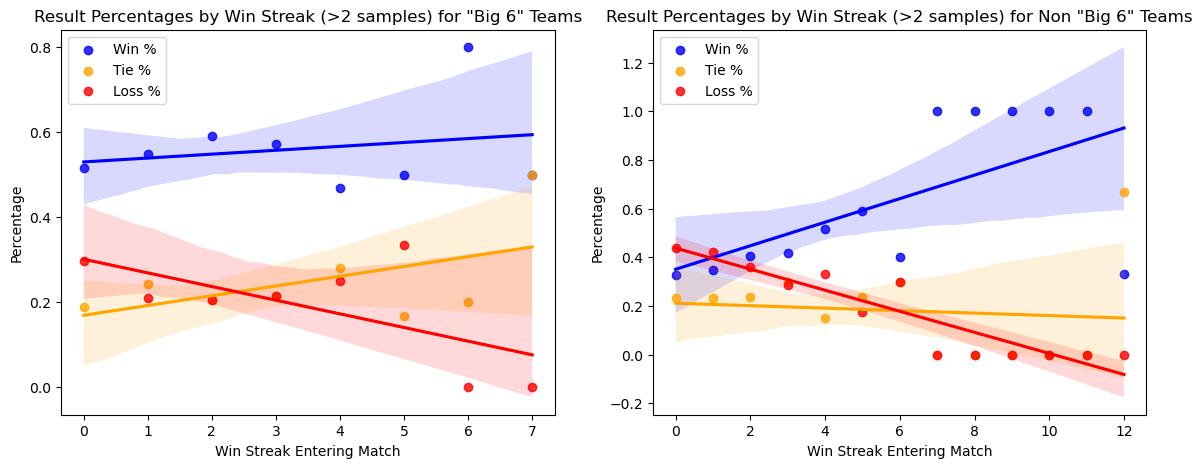

In [97]:
# Plotting regression line plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

big6_mask = big6_result_by_winstreak['SampleSize'] > 2
big6_reduced_data = big6_result_by_winstreak[big6_mask]

sns.regplot(x=big6_reduced_data.index, y=big6_reduced_data['WinPercentage'], color='blue', line_kws={'color': 'blue'}, label='Win %', ax=axes[0])
sns.regplot(x=big6_reduced_data.index, y=big6_reduced_data['TiePercentage'], color='orange', line_kws={'color': 'orange'}, label='Tie %', ax=axes[0])
sns.regplot(x=big6_reduced_data.index, y=big6_reduced_data['LossPercentage'], color='red', line_kws={'color': 'red'}, label='Loss %', ax=axes[0])
axes[0].set_xlabel("Win Streak Entering Match")
axes[0].set_ylabel("Percentage")
axes[0].set_title('Result Percentages by Win Streak (>2 samples) for "Big 6" Teams')
axes[0].legend()


other_mask = other_result_by_winstreak['SampleSize'] > 2
other_reduced_data = other_result_by_winstreak[other_mask]

sns.regplot(x=other_reduced_data.index, y=other_reduced_data['WinPercentage'], color='blue', line_kws={'color': 'blue'}, label='Win %', ax=axes[1])
sns.regplot(x=other_reduced_data.index, y=other_reduced_data['TiePercentage'], color='orange', line_kws={'color': 'orange'}, label='Tie %', ax=axes[1])
sns.regplot(x=other_reduced_data.index, y=other_reduced_data['LossPercentage'], color='red', line_kws={'color': 'red'}, label='Loss %', ax=axes[1])
axes[1].set_xlabel("Win Streak Entering Match")
axes[1].set_ylabel("Percentage")
axes[1].set_title('Result Percentages by Win Streak (>2 samples) for Non "Big 6" Teams')
axes[1].legend()

plt.show()

In [98]:
print('Result Percentages by Win Streak (>2 samples) for "Big 6" Teams:')
x1 = big6_reduced_data.index.values
reg_data1 = {'Win': big6_reduced_data['WinPercentage'].values, 'Tie': big6_reduced_data['TiePercentage'].values, 'Loss': big6_reduced_data['LossPercentage'].values}
for name, y1 in reg_data1.items():
    reg_line1 = linregress(x1, y1)
    print(name, "Slope:", reg_line1.slope)
    print(name, "Intercept:", reg_line1.intercept)
    print(name, "R-value:", reg_line1.rvalue)


print('\n\n\nResult Percentages by Win Streak (>2 samples) for Non "Big 6" Teams:')
x2 = other_reduced_data.index.values
reg_data2 = {'Win': other_reduced_data['WinPercentage'].values, 'Tie': other_reduced_data['TiePercentage'].values, 'Loss': other_reduced_data['LossPercentage'].values}
for name, y2 in reg_data2.items():
    reg_line2 = linregress(x2, y2)
    print(name, "Slope:", reg_line2.slope)
    print(name, "Intercept:", reg_line2.intercept)
    print(name, "R-value:", reg_line2.rvalue)

Result Percentages by Win Streak (>2 samples) for "Big 6" Teams:
Win Slope: 0.009162545774814998
Win Intercept: 0.529987618737497
Win R-value: 0.2148655536483946
Tie Slope: 0.02297442719864243
Tie Intercept: 0.16909614912303217
Tie R-value: 0.5257087685345102
Loss Slope: -0.03213697297345743
Loss Intercept: 0.3009162321394707
Loss R-value: -0.6310799965628134



Result Percentages by Win Streak (>2 samples) for Non "Big 6" Teams:
Win Slope: 0.048381994183966284
Win Intercept: 0.3507728545328057
Win R-value: 0.6206585783232793
Tie Slope: -0.005089023311894709
Tie Intercept: 0.2113770269226371
Tie R-value: -0.10356354626685936
Loss Slope: -0.04329297087207157
Loss Intercept: 0.4378501185445572
Loss R-value: -0.9223543162314405


We see that non-big 6 teams have a greater correlation between win streak and win % (positive correlation) and win streak and loss % (negative correlation) (as seen by the greater r values). We do see a much greater correlation between win streak and loss percentage then win streak and win percentage for both of these. However, big 6 teams have a greater correlation between tie % and wins streak (positive correlation).

### b) Using Unbeaten Streak as the Momentum Metric

In [102]:
# Remaking unbeaten streak dataframes to ensure one has only "Big 6" teams and one has only non "Big 6 teams"
# "Big 6"
big6_unbeaten_streaks = df_big6.groupby('UnbeatenStreakBefore')
big6_unbeaten_streak_counts = big6_unbeaten_streaks.size()
big6_result_by_unbeatenstreak = big6_unbeaten_streak_counts.to_frame() # Transforming series of win streak counts to dataframe
big6_result_by_unbeatenstreak.columns = ['SampleSize'] # Naming column
big6_result_by_unbeatenstreak['WinPercentage'] = (df_big6.groupby('UnbeatenStreakBefore')['Result'].apply(lambda x: (x == 'W').mean())) # Calculating WinPercentage by WinStreak
big6_result_by_unbeatenstreak['TiePercentage'] = (df_big6.groupby('UnbeatenStreakBefore')['Result'].apply(lambda x: (x == 'T').mean())) # Calculating TiePercentage by WinStreak
big6_result_by_unbeatenstreak['LossPercentage'] = (df_big6.groupby('UnbeatenStreakBefore')['Result'].apply(lambda x: (x == 'L').mean())) # Calculating LossPercentage by WinStreak

# Non "Big 6"
other_unbeaten_streaks = df_other.groupby('UnbeatenStreakBefore')
other_unbeaten_streak_counts = other_unbeaten_streaks.size()
other_result_by_unbeatenstreak = other_unbeaten_streak_counts.to_frame() # Transforming series of win streak counts to dataframe
other_result_by_unbeatenstreak.columns = ['SampleSize'] # Naming column
other_result_by_unbeatenstreak['WinPercentage'] = (df_other.groupby('UnbeatenStreakBefore')['Result'].apply(lambda x: (x == 'W').mean())) # Calculating WinPercentage by WinStreak
other_result_by_unbeatenstreak['TiePercentage'] = (df_other.groupby('UnbeatenStreakBefore')['Result'].apply(lambda x: (x == 'T').mean())) # Calculating TiePercentage by WinStreak
other_result_by_unbeatenstreak['LossPercentage'] = (df_other.groupby('UnbeatenStreakBefore')['Result'].apply(lambda x: (x == 'L').mean())) # Calculating LossPercentage by WinStreak

In [104]:
big6_result_by_unbeatenstreak

,SampleSize,WinPercentage,TiePercentage,LossPercentage
UnbeatenStreakBefore,,,,
0,209,0.497608,0.196172,0.306220
1,138,0.485507,0.195652,0.318841
2,93,0.537634,0.204301,0.258065
3,68,0.647059,0.161765,0.191176
4,53,0.547170,0.264151,0.188679
5,42,0.619048,0.261905,0.119048
6,34,0.588235,0.205882,0.205882
7,27,0.666667,0.185185,0.148148
8,23,0.565217,0.217391,0.217391


In [105]:
other_result_by_unbeatenstreak

,SampleSize,WinPercentage,TiePercentage,LossPercentage
UnbeatenStreakBefore,,,,
0,1313,0.314547,0.234577,0.450876
1,709,0.339915,0.221439,0.438646
2,390,0.351282,0.253846,0.394872
3,232,0.366379,0.267241,0.366379
4,141,0.404255,0.205674,0.390071
5,84,0.357143,0.190476,0.452381
6,45,0.444444,0.222222,0.333333
7,29,0.482759,0.206897,0.310345
8,20,0.600000,0.200000,0.200000


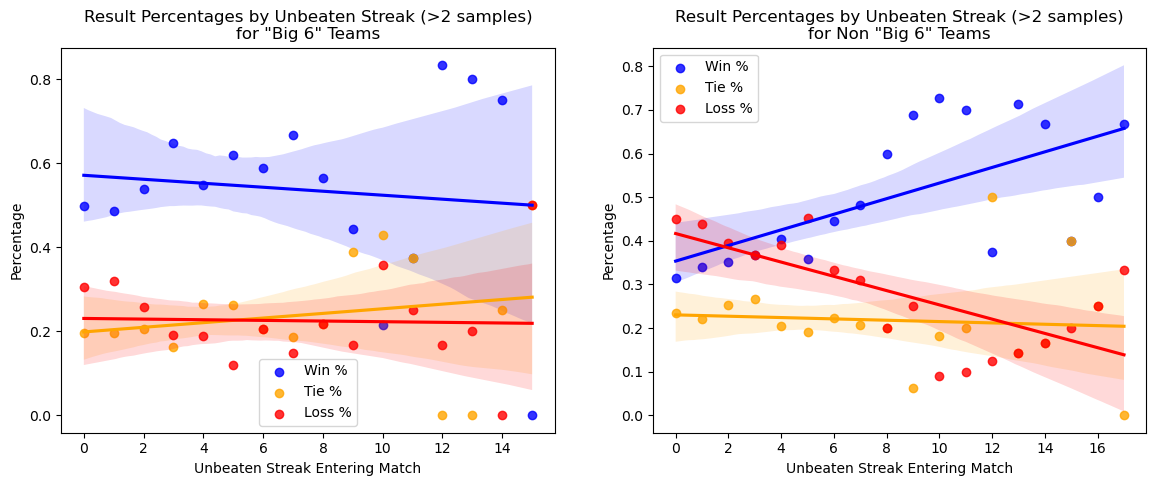

In [111]:
# Plotting regression line plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

big6_mask = big6_result_by_unbeatenstreak['SampleSize'] > 2
big6_reduced_data = big6_result_by_unbeatenstreak[big6_mask]

sns.regplot(x=big6_reduced_data.index, y=big6_reduced_data['WinPercentage'], color='blue', line_kws={'color': 'blue'}, label='Win %', ax=axes[0])
sns.regplot(x=big6_reduced_data.index, y=big6_reduced_data['TiePercentage'], color='orange', line_kws={'color': 'orange'}, label='Tie %', ax=axes[0])
sns.regplot(x=big6_reduced_data.index, y=big6_reduced_data['LossPercentage'], color='red', line_kws={'color': 'red'}, label='Loss %', ax=axes[0])
axes[0].set_xlabel("Unbeaten Streak Entering Match")
axes[0].set_ylabel("Percentage")
axes[0].set_title('Result Percentages by Unbeaten Streak (>2 samples)\nfor "Big 6" Teams')
axes[0].legend()


other_mask = other_result_by_unbeatenstreak['SampleSize'] > 2
other_reduced_data = other_result_by_unbeatenstreak[other_mask]

sns.regplot(x=other_reduced_data.index, y=other_reduced_data['WinPercentage'], color='blue', line_kws={'color': 'blue'}, label='Win %', ax=axes[1])
sns.regplot(x=other_reduced_data.index, y=other_reduced_data['TiePercentage'], color='orange', line_kws={'color': 'orange'}, label='Tie %', ax=axes[1])
sns.regplot(x=other_reduced_data.index, y=other_reduced_data['LossPercentage'], color='red', line_kws={'color': 'red'}, label='Loss %', ax=axes[1])
axes[1].set_xlabel("Unbeaten Streak Entering Match")
axes[1].set_ylabel("Percentage")
axes[1].set_title('Result Percentages by Unbeaten Streak (>2 samples)\nfor Non "Big 6" Teams')
axes[1].set_xticks(range(0,18,2))
axes[1].legend()

plt.show()

In [107]:
print('Result Percentages by Unbeaten Streak (>2 samples) for "Big 6" Teams:')
x1 = big6_reduced_data.index.values
reg_data1 = {'Win': big6_reduced_data['WinPercentage'].values, 'Tie': big6_reduced_data['TiePercentage'].values, 'Loss': big6_reduced_data['LossPercentage'].values}
for name, y1 in reg_data1.items():
    reg_line1 = linregress(x1, y1)
    print(name, "Slope:", reg_line1.slope)
    print(name, "Intercept:", reg_line1.intercept)
    print(name, "R-value:", reg_line1.rvalue)


print('\n\n\nResult Percentages by Unbeaten Streak (>2 samples) for Non "Big 6" Teams:')
x2 = other_reduced_data.index.values
reg_data2 = {'Win': other_reduced_data['WinPercentage'].values, 'Tie': other_reduced_data['TiePercentage'].values, 'Loss': other_reduced_data['LossPercentage'].values}
for name, y2 in reg_data2.items():
    reg_line2 = linregress(x2, y2)
    print(name, "Slope:", reg_line2.slope)
    print(name, "Intercept:", reg_line2.intercept)
    print(name, "R-value:", reg_line2.rvalue)

Result Percentages by Unbeaten Streak (>2 samples) for "Big 6" Teams:
Win Slope: -0.004742701425381662
Win Intercept: 0.5712707862235684
Win R-value: -0.10659734989434082
Tie Slope: 0.005516538651088794
Tie Intercept: 0.19830502693580496
Tie R-value: 0.1936640728489431
Loss Slope: -0.0007738372257071291
Loss Intercept: 0.23042418684062668
Loss R-value: -0.032884201380045254



Result Percentages by Unbeaten Streak (>2 samples) for Non "Big 6" Teams:
Win Slope: 0.01789256384457021
Win Intercept: 0.35336412904391595
Win R-value: 0.625596763288417
Tie Slope: -0.0015358563395784478
Tie Intercept: 0.23006667875590442
Tie R-value: -0.07547169674580077
Loss Slope: -0.016356707504991762
Loss Intercept: 0.4165691922001796
Loss R-value: -0.7036677483431796


We see that non "big-6" teams have a stronger correlation between result and unbeaten streak.

### c) Using Points Earned in the Last N Matches (n = 3 or 5) as the Momentum Metric

### n = 3:

In [112]:
# Remaking last 3 points dataframes to ensure one has only "Big 6" teams and one has only non "Big 6 teams"
# "Big 6"
big6_last3points = df_big6.groupby('Last3Points')
big6_last3points_counts = big6_last3points.size()
big6_result_by_last3points = big6_last3points_counts.to_frame() # Transforming series of win streak counts to dataframe
big6_result_by_last3points.columns = ['SampleSize'] # Naming column
big6_result_by_last3points['WinPercentage'] = (df_big6.groupby('Last3Points')['Result'].apply(lambda x: (x == 'W').mean())) # Calculating WinPercentage by WinStreak
big6_result_by_last3points['TiePercentage'] = (df_big6.groupby('Last3Points')['Result'].apply(lambda x: (x == 'T').mean())) # Calculating TiePercentage by WinStreak
big6_result_by_last3points['LossPercentage'] = (df_big6.groupby('Last3Points')['Result'].apply(lambda x: (x == 'L').mean())) # Calculating LossPercentage by WinStreak

# Non "Big 6"
other_last3points = df_other.groupby('Last3Points')
other_last3points_counts = other_last3points.size()
other_result_by_last3points = other_last3points_counts.to_frame() # Transforming series of win streak counts to dataframe
other_result_by_last3points.columns = ['SampleSize'] # Naming column
other_result_by_last3points['WinPercentage'] = (df_other.groupby('Last3Points')['Result'].apply(lambda x: (x == 'W').mean())) # Calculating WinPercentage by WinStreak
other_result_by_last3points['TiePercentage'] = (df_other.groupby('Last3Points')['Result'].apply(lambda x: (x == 'T').mean())) # Calculating TiePercentage by WinStreak
other_result_by_last3points['LossPercentage'] = (df_other.groupby('Last3Points')['Result'].apply(lambda x: (x == 'L').mean())) # Calculating LossPercentage by WinStreak

In [116]:
big6_result_by_last3points

,SampleSize,WinPercentage,TiePercentage,LossPercentage
Last3Points,,,,
0,41,0.585366,0.195122,0.219512
1,45,0.444444,0.177778,0.377778
2,19,0.631579,0.105263,0.263158
3,99,0.474747,0.191919,0.333333
4,112,0.473214,0.196429,0.330357
5,60,0.733333,0.116667,0.150000
6,126,0.515873,0.222222,0.261905
7,145,0.565517,0.268966,0.165517
9,113,0.539823,0.247788,0.212389


In [117]:
other_result_by_last3points

,SampleSize,WinPercentage,TiePercentage,LossPercentage
Last3Points,,,,
0,376,0.284574,0.210106,0.505319
1,398,0.291457,0.221106,0.487437
2,204,0.299020,0.299020,0.401961
3,557,0.319569,0.235189,0.445242
4,538,0.356877,0.237918,0.405204
5,156,0.352564,0.250000,0.397436
6,376,0.388298,0.226064,0.385638
7,268,0.440299,0.205224,0.354478
9,167,0.514970,0.233533,0.251497


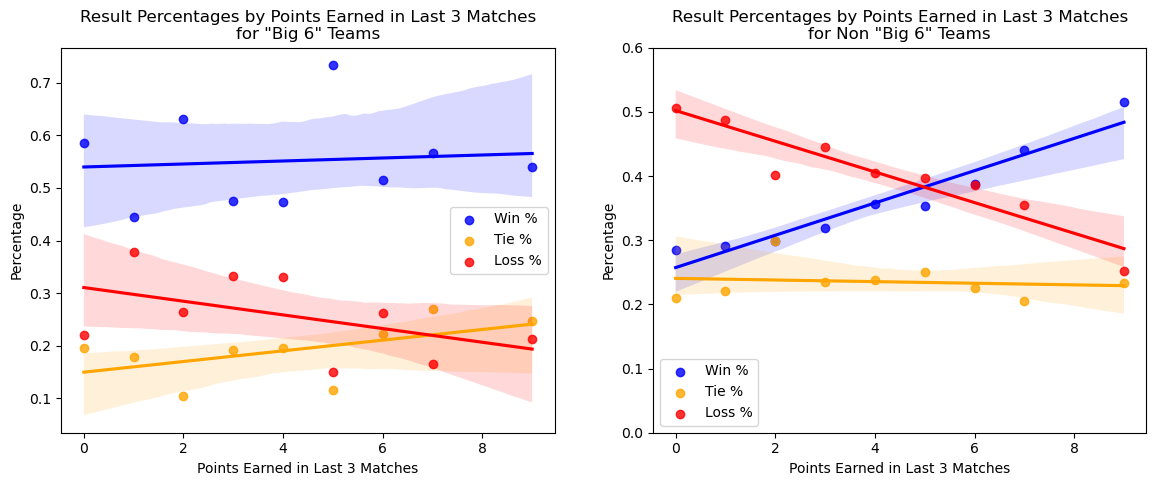

In [123]:
# Plotting regression line plots
# Don't need 'masks' because all of the groups have a sample size > 2
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.regplot(x=big6_result_by_last3points.index, y=big6_result_by_last3points['WinPercentage'], color='blue', line_kws={'color': 'blue'}, label='Win %', ax=axes[0])
sns.regplot(x=big6_result_by_last3points.index, y=big6_result_by_last3points['TiePercentage'], color='orange', line_kws={'color': 'orange'}, label='Tie %', ax=axes[0])
sns.regplot(x=big6_result_by_last3points.index, y=big6_result_by_last3points['LossPercentage'], color='red', line_kws={'color': 'red'}, label='Loss %', ax=axes[0])
axes[0].set_xlabel("Points Earned in Last 3 Matches")
axes[0].set_ylabel("Percentage")
axes[0].set_title('Result Percentages by Points Earned in Last 3 Matches\nfor "Big 6" Teams')
axes[0].legend()

sns.regplot(x=other_result_by_last3points.index, y=other_result_by_last3points['WinPercentage'], color='blue', line_kws={'color': 'blue'}, label='Win %', ax=axes[1])
sns.regplot(x=other_result_by_last3points.index, y=other_result_by_last3points['TiePercentage'], color='orange', line_kws={'color': 'orange'}, label='Tie %', ax=axes[1])
sns.regplot(x=other_result_by_last3points.index, y=other_result_by_last3points['LossPercentage'], color='red', line_kws={'color': 'red'}, label='Loss %', ax=axes[1])
axes[1].set_xlabel("Points Earned in Last 3 Matches")
axes[1].set_ylabel("Percentage")
axes[1].set_title('Result Percentages by Points Earned in Last 3 Matches\nfor Non "Big 6" Teams')
axes[1].set_yticks([i/10 for i in range(0,7)])
axes[1].legend()

plt.show()

In [124]:
print('Result Percentages by Points Earned in Last 3 Matches for "Big 6" Teams:')
x1 = big6_result_by_last3points.index.values
reg_data1 = {'Win': big6_result_by_last3points['WinPercentage'].values, 'Tie': big6_result_by_last3points['TiePercentage'].values, 'Loss': big6_result_by_last3points['LossPercentage'].values}
for name, y1 in reg_data1.items():
    reg_line1 = linregress(x1, y1)
    print(name, "Slope:", reg_line1.slope)
    print(name, "Intercept:", reg_line1.intercept)
    print(name, "R-value:", reg_line1.rvalue)


print('\n\n\nResult Percentages by Points Earned in Last 3 Matches for Non "Big 6" Teams:')
x2 = other_result_by_last3points.index.values
reg_data2 = {'Win': other_result_by_last3points['WinPercentage'].values, 'Tie': other_result_by_last3points['TiePercentage'].values, 'Loss': other_result_by_last3points['LossPercentage'].values}
for name, y2 in reg_data2.items():
    reg_line2 = linregress(x2, y2)
    print(name, "Slope:", reg_line2.slope)
    print(name, "Intercept:", reg_line2.intercept)
    print(name, "R-value:", reg_line2.rvalue)

Result Percentages by Points Earned in Last 3 Matches for "Big 6" Teams:
Win Slope: 0.002852416997985817
Win Intercept: 0.5398175751603227
Win R-value: 0.09236060678914429
Tie Slope: 0.010151546714715142
Tie Intercept: 0.1496161598383408
Tie R-value: 0.5510941446825163
Loss Slope: -0.013003963712700958
Loss Intercept: 0.3105662650013365
Loss R-value: -0.48723565555290155



Result Percentages by Points Earned in Last 3 Matches for Non "Big 6" Teams:
Win Slope: 0.025167774297578688
Win Intercept: 0.2573800777005305
Win R-value: 0.9628934471581166
Tie Slope: -0.0012608253286396716
Tie Intercept: 0.24053438062482385
Tie R-value: -0.1338524277381241
Loss Slope: -0.02390694896893902
Loss Intercept: 0.5020855416746457
Loss R-value: -0.9351464821692254


There is a much stronger correlation between points earned in the last 3 matches and match outcome for non "big 6" teams than "big 6" teams with the exception of tie %.

### n = 5:

In [114]:
# Remaking last 5 points dataframes to ensure one has only "Big 6" teams and one has only non "Big 6 teams"
# "Big 6"
big6_last5points = df_big6.groupby('Last5Points')
big6_last5points_counts = big6_last5points.size()
big6_result_by_last5points = big6_last5points_counts.to_frame() # Transforming series of win streak counts to dataframe
big6_result_by_last5points.columns = ['SampleSize'] # Naming column
big6_result_by_last5points['WinPercentage'] = (df_big6.groupby('Last5Points')['Result'].apply(lambda x: (x == 'W').mean())) # Calculating WinPercentage by WinStreak
big6_result_by_last5points['TiePercentage'] = (df_big6.groupby('Last5Points')['Result'].apply(lambda x: (x == 'T').mean())) # Calculating TiePercentage by WinStreak
big6_result_by_last5points['LossPercentage'] = (df_big6.groupby('Last5Points')['Result'].apply(lambda x: (x == 'L').mean())) # Calculating LossPercentage by WinStreak

# Non "Big 6"
other_last5points = df_other.groupby('Last5Points')
other_last5points_counts = other_last5points.size()
other_result_by_last5points = other_last5points_counts.to_frame() # Transforming series of win streak counts to dataframe
other_result_by_last5points.columns = ['SampleSize'] # Naming column
other_result_by_last5points['WinPercentage'] = (df_other.groupby('Last5Points')['Result'].apply(lambda x: (x == 'W').mean())) # Calculating WinPercentage by WinStreak
other_result_by_last5points['TiePercentage'] = (df_other.groupby('Last5Points')['Result'].apply(lambda x: (x == 'T').mean())) # Calculating TiePercentage by WinStreak
other_result_by_last5points['LossPercentage'] = (df_other.groupby('Last5Points')['Result'].apply(lambda x: (x == 'L').mean())) # Calculating LossPercentage by WinStreak

In [118]:
big6_result_by_last5points

,SampleSize,WinPercentage,TiePercentage,LossPercentage
Last5Points,,,,
0,25,0.600000,0.200000,0.200000
1,16,0.500000,0.125000,0.375000
2,5,0.400000,0.000000,0.600000
3,35,0.600000,0.228571,0.171429
4,50,0.480000,0.080000,0.440000
5,28,0.607143,0.214286,0.178571
6,64,0.609375,0.187500,0.203125
7,74,0.405405,0.229730,0.364865
8,66,0.530303,0.181818,0.287879


In [119]:
other_result_by_last5points

,SampleSize,WinPercentage,TiePercentage,LossPercentage
Last5Points,,,,
0,211,0.284360,0.218009,0.497630
1,184,0.233696,0.190217,0.576087
2,131,0.305344,0.274809,0.419847
3,302,0.274834,0.248344,0.476821
4,347,0.311239,0.242075,0.446686
5,248,0.342742,0.225806,0.431452
6,316,0.313291,0.284810,0.401899
7,372,0.387097,0.212366,0.400538
8,206,0.354369,0.252427,0.393204


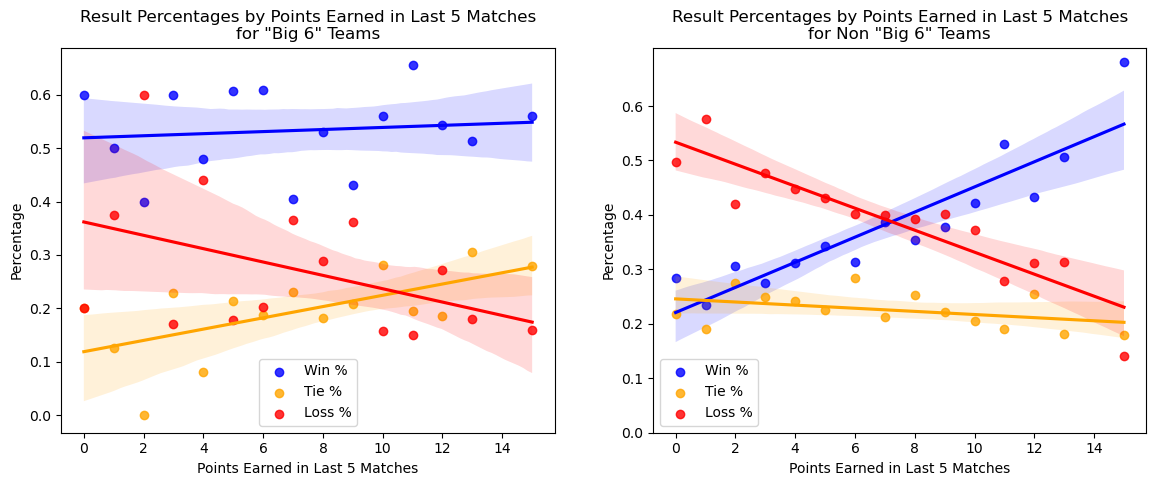

In [125]:
# Plotting regression line plots
# Don't need 'masks' because all of the groups have a sample size > 2
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.regplot(x=big6_result_by_last5points.index, y=big6_result_by_last5points['WinPercentage'], color='blue', line_kws={'color': 'blue'}, label='Win %', ax=axes[0])
sns.regplot(x=big6_result_by_last5points.index, y=big6_result_by_last5points['TiePercentage'], color='orange', line_kws={'color': 'orange'}, label='Tie %', ax=axes[0])
sns.regplot(x=big6_result_by_last5points.index, y=big6_result_by_last5points['LossPercentage'], color='red', line_kws={'color': 'red'}, label='Loss %', ax=axes[0])
axes[0].set_xlabel("Points Earned in Last 5 Matches")
axes[0].set_ylabel("Percentage")
axes[0].set_title('Result Percentages by Points Earned in Last 5 Matches\nfor "Big 6" Teams')
axes[0].legend()

sns.regplot(x=other_result_by_last5points.index, y=other_result_by_last5points['WinPercentage'], color='blue', line_kws={'color': 'blue'}, label='Win %', ax=axes[1])
sns.regplot(x=other_result_by_last5points.index, y=other_result_by_last5points['TiePercentage'], color='orange', line_kws={'color': 'orange'}, label='Tie %', ax=axes[1])
sns.regplot(x=other_result_by_last5points.index, y=other_result_by_last5points['LossPercentage'], color='red', line_kws={'color': 'red'}, label='Loss %', ax=axes[1])
axes[1].set_xlabel("Points Earned in Last 5 Matches")
axes[1].set_ylabel("Percentage")
axes[1].set_title('Result Percentages by Points Earned in Last 5 Matches\nfor Non "Big 6" Teams')
axes[1].set_yticks([i/10 for i in range(0,7)])
axes[1].legend()

plt.show()

In [126]:
print('Result Percentages by Points Earned in Last 5 Matches for "Big 6" Teams:')
x1 = big6_result_by_last5points.index.values
reg_data1 = {'Win': big6_result_by_last5points['WinPercentage'].values, 'Tie': big6_result_by_last5points['TiePercentage'].values, 'Loss': big6_result_by_last5points['LossPercentage'].values}
for name, y1 in reg_data1.items():
    reg_line1 = linregress(x1, y1)
    print(name, "Slope:", reg_line1.slope)
    print(name, "Intercept:", reg_line1.intercept)
    print(name, "R-value:", reg_line1.rvalue)


print('\n\n\nResult Percentages by Points Earned in Last 5 Matches for Non "Big 6" Teams:')
x2 = other_result_by_last5points.index.values
reg_data2 = {'Win': other_result_by_last5points['WinPercentage'].values, 'Tie': other_result_by_last5points['TiePercentage'].values, 'Loss': other_result_by_last5points['LossPercentage'].values}
for name, y2 in reg_data2.items():
    reg_line2 = linregress(x2, y2)
    print(name, "Slope:", reg_line2.slope)
    print(name, "Intercept:", reg_line2.intercept)
    print(name, "R-value:", reg_line2.rvalue)

Result Percentages by Points Earned in Last 5 Matches for "Big 6" Teams:
Win Slope: 0.001944693294084778
Win Intercept: 0.5192702768685257
Win R-value: 0.11417098150909612
Tie Slope: 0.010555590157647203
Tie Intercept: 0.11894881121853772
Tie R-value: 0.6178461651193491
Loss Slope: -0.01250028345173198
Loss Intercept: 0.3617809119129367
Loss R-value: -0.4374943939091668



Result Percentages by Points Earned in Last 5 Matches for Non "Big 6" Teams:
Win Slope: 0.023065419705833243
Win Intercept: 0.22072614888159509
Win R-value: 0.9060541637574901
Tie Slope: -0.002870700353885705
Tie Intercept: 0.2457904937420992
Tie R-value: -0.39529469541973156
Loss Slope: -0.020194719351947537
Loss Intercept: 0.5334833573763057
Loss R-value: -0.904296250444386


There is again a much stronger correlation between points earned in the last 3 matches and match outcome for non "big 6" teams than "big 6" teams with the exception of tie %.

### d) Using Goal Differential in the Last N Matches (n = 3 or 5) as the Momentum Metric

### n = 3:

In [130]:
# Remaking last 3 goal differential dataframes to ensure one has only "Big 6" teams and one has only non "Big 6 teams"
# "Big 6"
big6_last3GD = df_big6.groupby('Last3GD')
big6_last3GD_counts = big6_last3GD.size()
big6_result_by_last3GD = big6_last3GD_counts.to_frame() # Transforming series of win streak counts to dataframe
big6_result_by_last3GD.columns = ['SampleSize'] # Naming column
big6_result_by_last3GD['WinPercentage'] = (df_big6.groupby('Last3GD')['Result'].apply(lambda x: (x == 'W').mean())) # Calculating WinPercentage by WinStreak
big6_result_by_last3GD['TiePercentage'] = (df_big6.groupby('Last3GD')['Result'].apply(lambda x: (x == 'T').mean())) # Calculating TiePercentage by WinStreak
big6_result_by_last3GD['LossPercentage'] = (df_big6.groupby('Last3GD')['Result'].apply(lambda x: (x == 'L').mean())) # Calculating LossPercentage by WinStreak

# Non "Big 6"
other_last3GD = df_other.groupby('Last3GD')
other_last3GD_counts = other_last3GD.size()
other_result_by_last3GD = other_last3GD_counts.to_frame() # Transforming series of win streak counts to dataframe
other_result_by_last3GD.columns = ['SampleSize'] # Naming column
other_result_by_last3GD['WinPercentage'] = (df_other.groupby('Last3GD')['Result'].apply(lambda x: (x == 'W').mean())) # Calculating WinPercentage by WinStreak
other_result_by_last3GD['TiePercentage'] = (df_other.groupby('Last3GD')['Result'].apply(lambda x: (x == 'T').mean())) # Calculating TiePercentage by WinStreak
other_result_by_last3GD['LossPercentage'] = (df_other.groupby('Last3GD')['Result'].apply(lambda x: (x == 'L').mean())) # Calculating LossPercentage by WinStreak

In [131]:
big6_result_by_last3GD

,SampleSize,WinPercentage,TiePercentage,LossPercentage
Last3GD,,,,
-9,1,1.000000,0.000000,0.000000
-8,1,1.000000,0.000000,0.000000
-7,3,0.333333,0.333333,0.333333
-6,6,0.500000,0.000000,0.500000
-5,10,0.500000,0.200000,0.300000
-4,19,0.368421,0.210526,0.421053
-3,36,0.416667,0.250000,0.333333
-2,39,0.538462,0.025641,0.435897
-1,46,0.543478,0.108696,0.347826


In [132]:
other_result_by_last3GD

,SampleSize,WinPercentage,TiePercentage,LossPercentage
Last3GD,,,,
-16,1,0.000000,1.000000,0.000000
-12,5,0.200000,0.200000,0.600000
-11,8,0.250000,0.125000,0.625000
-10,13,0.153846,0.461538,0.384615
-9,14,0.214286,0.142857,0.642857
-8,37,0.270270,0.135135,0.594595
-7,47,0.234043,0.212766,0.553191
-6,76,0.236842,0.289474,0.473684
-5,147,0.272109,0.238095,0.489796


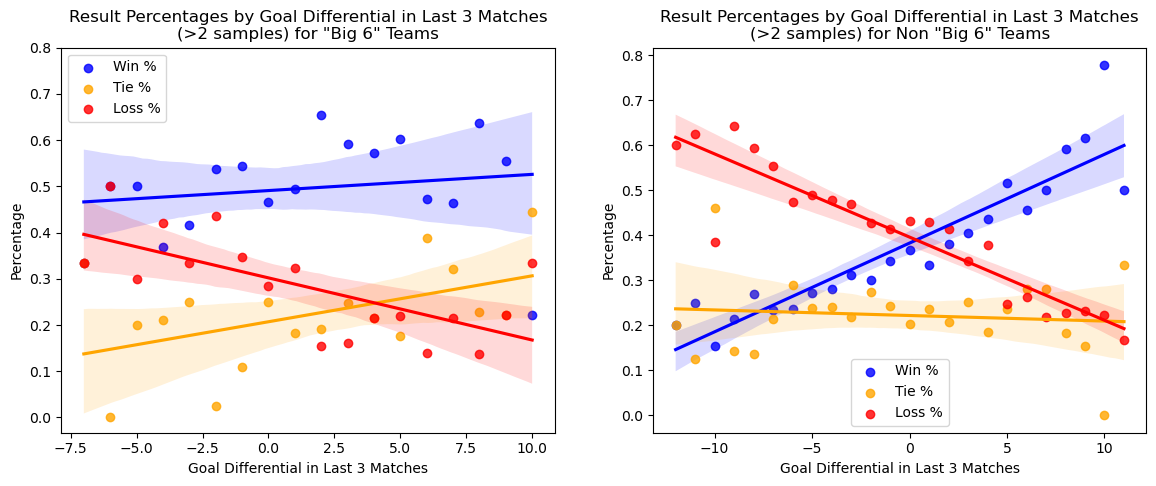

In [139]:
# Plotting regression line plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

big6_mask = big6_result_by_last3GD['SampleSize'] > 2
big6_reduced_data = big6_result_by_last3GD[big6_mask]

sns.regplot(x=big6_reduced_data.index, y=big6_reduced_data['WinPercentage'], color='blue', line_kws={'color': 'blue'}, label='Win %', ax=axes[0])
sns.regplot(x=big6_reduced_data.index, y=big6_reduced_data['TiePercentage'], color='orange', line_kws={'color': 'orange'}, label='Tie %', ax=axes[0])
sns.regplot(x=big6_reduced_data.index, y=big6_reduced_data['LossPercentage'], color='red', line_kws={'color': 'red'}, label='Loss %', ax=axes[0])
axes[0].set_xlabel("Goal Differential in Last 3 Matches")
axes[0].set_ylabel("Percentage")
axes[0].set_title('Result Percentages by Goal Differential in Last 3 Matches\n(>2 samples) for "Big 6" Teams')
axes[0].set_yticks([i/10 for i in range(0,9)])
axes[0].legend()


other_mask = other_result_by_last3GD['SampleSize'] > 2
other_reduced_data = other_result_by_last3GD[other_mask]

sns.regplot(x=other_reduced_data.index, y=other_reduced_data['WinPercentage'], color='blue', line_kws={'color': 'blue'}, label='Win %', ax=axes[1])
sns.regplot(x=other_reduced_data.index, y=other_reduced_data['TiePercentage'], color='orange', line_kws={'color': 'orange'}, label='Tie %', ax=axes[1])
sns.regplot(x=other_reduced_data.index, y=other_reduced_data['LossPercentage'], color='red', line_kws={'color': 'red'}, label='Loss %', ax=axes[1])
axes[1].set_xlabel("Goal Differential in Last 3 Matches")
axes[1].set_ylabel("Percentage")
axes[1].set_title('Result Percentages by Goal Differential in Last 3 Matches\n(>2 samples) for Non "Big 6" Teams')
axes[1].legend()

plt.show()

In [140]:
print('Result Percentages by Goal Differential in Last 3 Matches (>2 samples) for "Big 6" Teams:')
x1 = big6_reduced_data.index.values
reg_data1 = {'Win': big6_reduced_data['WinPercentage'].values, 'Tie': big6_reduced_data['TiePercentage'].values, 'Loss': big6_reduced_data['LossPercentage'].values}
for name, y1 in reg_data1.items():
    reg_line1 = linregress(x1, y1)
    print(name, "Slope:", reg_line1.slope)
    print(name, "Intercept:", reg_line1.intercept)
    print(name, "R-value:", reg_line1.rvalue)


print('\n\n\nResult Percentages by Goal Differential in Last 3 Matches (>2 samples) for Non "Big 6" Teams:')
x2 = other_reduced_data.index.values
reg_data2 = {'Win': other_reduced_data['WinPercentage'].values, 'Tie': other_reduced_data['TiePercentage'].values, 'Loss': other_reduced_data['LossPercentage'].values}
for name, y2 in reg_data2.items():
    reg_line2 = linregress(x2, y2)
    print(name, "Slope:", reg_line2.slope)
    print(name, "Intercept:", reg_line2.intercept)
    print(name, "R-value:", reg_line2.rvalue)

Result Percentages by Goal Differential in Last 3 Matches (>2 samples) for "Big 6" Teams:
Win Slope: 0.0035072041153948255
Win Intercept: 0.49091456608483997
Win R-value: 0.17052635389458146
Tie Slope: 0.009940038405335982
Tie Intercept: 0.2070690925533861
Tie R-value: 0.4800874258739677
Loss Slope: -0.013447242520730809
Loss Intercept: 0.3020163413617738
Loss R-value: -0.672089245507708



Result Percentages by Goal Differential in Last 3 Matches (>2 samples) for Non "Big 6" Teams:
Win Slope: 0.019722313920068894
Win Intercept: 0.38257518937274004
Win R-value: 0.9175789809415547
Tie Slope: -0.0012378500458994515
Tie Intercept: 0.22159584535012383
Tie R-value: -0.10253645604717777
Loss Slope: -0.01848446387416944
Loss Intercept: 0.3958289652771362
Loss R-value: -0.9232721736422902


Again there is a much stronger correlation between points earned in the last 3 matches and match outcome for non "big 6" teams than "big 6" teams with the exception of tie %.

### n = 5:

In [141]:
# Remaking last 5 goal differential dataframes to ensure one has only "Big 6" teams and one has only non "Big 6 teams"
# "Big 6"
big6_last5GD = df_big6.groupby('Last5GD')
big6_last5GD_counts = big6_last5GD.size()
big6_result_by_last5GD = big6_last5GD_counts.to_frame() # Transforming series of win streak counts to dataframe
big6_result_by_last5GD.columns = ['SampleSize'] # Naming column
big6_result_by_last5GD['WinPercentage'] = (df_big6.groupby('Last5GD')['Result'].apply(lambda x: (x == 'W').mean())) # Calculating WinPercentage by WinStreak
big6_result_by_last5GD['TiePercentage'] = (df_big6.groupby('Last5GD')['Result'].apply(lambda x: (x == 'T').mean())) # Calculating TiePercentage by WinStreak
big6_result_by_last5GD['LossPercentage'] = (df_big6.groupby('Last5GD')['Result'].apply(lambda x: (x == 'L').mean())) # Calculating LossPercentage by WinStreak

# Non "Big 6"
other_last5GD = df_other.groupby('Last5GD')
other_last5GD_counts = other_last5GD.size()
other_result_by_last5GD = other_last5GD_counts.to_frame() # Transforming series of win streak counts to dataframe
other_result_by_last5GD.columns = ['SampleSize'] # Naming column
other_result_by_last5GD['WinPercentage'] = (df_other.groupby('Last5GD')['Result'].apply(lambda x: (x == 'W').mean())) # Calculating WinPercentage by WinStreak
other_result_by_last5GD['TiePercentage'] = (df_other.groupby('Last5GD')['Result'].apply(lambda x: (x == 'T').mean())) # Calculating TiePercentage by WinStreak
other_result_by_last5GD['LossPercentage'] = (df_other.groupby('Last5GD')['Result'].apply(lambda x: (x == 'L').mean())) # Calculating LossPercentage by WinStreak

In [142]:
big6_result_by_last5GD

,SampleSize,WinPercentage,TiePercentage,LossPercentage
Last5GD,,,,
-9,3,0.333333,0.000000,0.666667
-8,2,0.500000,0.000000,0.500000
-7,4,0.750000,0.250000,0.000000
-6,17,0.529412,0.058824,0.411765
-5,12,0.416667,0.166667,0.416667
-4,16,0.187500,0.187500,0.625000
-3,21,0.476190,0.142857,0.380952
-2,36,0.611111,0.138889,0.250000
-1,46,0.586957,0.195652,0.217391


In [143]:
other_result_by_last5GD

,SampleSize,WinPercentage,TiePercentage,LossPercentage
Last5GD,,,,
-18,1,1.000000,0.000000,0.000000
-16,2,0.500000,0.000000,0.500000
-15,4,0.000000,0.500000,0.500000
-14,8,0.125000,0.500000,0.375000
-13,10,0.200000,0.200000,0.600000
-12,23,0.217391,0.130435,0.652174
-11,24,0.125000,0.208333,0.666667
-10,26,0.307692,0.230769,0.461538
-9,64,0.218750,0.203125,0.578125


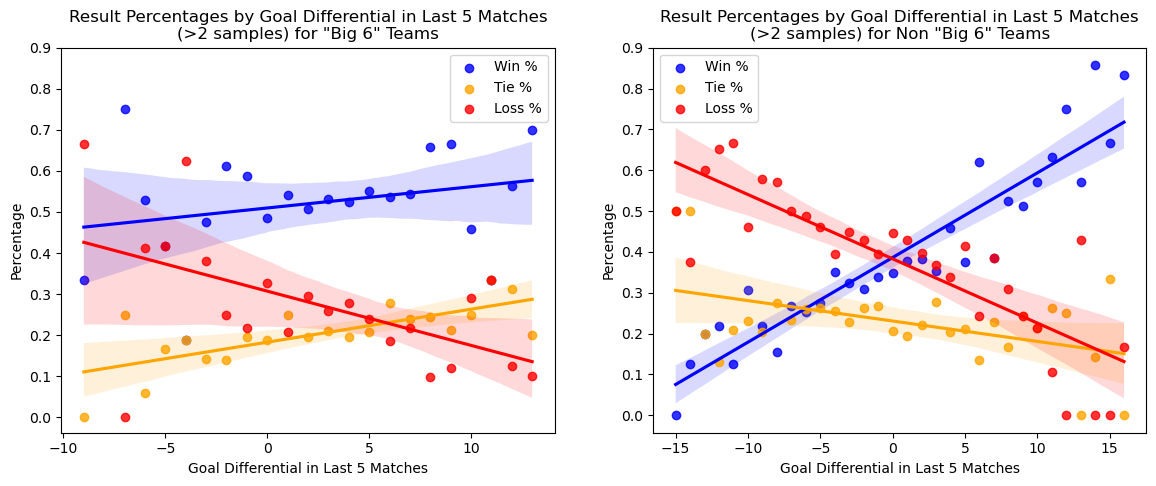

In [146]:
# Plotting regression line plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

big6_mask = big6_result_by_last5GD['SampleSize'] > 2
big6_reduced_data = big6_result_by_last5GD[big6_mask]

sns.regplot(x=big6_reduced_data.index, y=big6_reduced_data['WinPercentage'], color='blue', line_kws={'color': 'blue'}, label='Win %', ax=axes[0])
sns.regplot(x=big6_reduced_data.index, y=big6_reduced_data['TiePercentage'], color='orange', line_kws={'color': 'orange'}, label='Tie %', ax=axes[0])
sns.regplot(x=big6_reduced_data.index, y=big6_reduced_data['LossPercentage'], color='red', line_kws={'color': 'red'}, label='Loss %', ax=axes[0])
axes[0].set_xlabel("Goal Differential in Last 5 Matches")
axes[0].set_ylabel("Percentage")
axes[0].set_title('Result Percentages by Goal Differential in Last 5 Matches\n(>2 samples) for "Big 6" Teams')
axes[0].set_yticks([i/10 for i in range(0,10)])
axes[0].legend()


other_mask = other_result_by_last5GD['SampleSize'] > 2
other_reduced_data = other_result_by_last5GD[other_mask]

sns.regplot(x=other_reduced_data.index, y=other_reduced_data['WinPercentage'], color='blue', line_kws={'color': 'blue'}, label='Win %', ax=axes[1])
sns.regplot(x=other_reduced_data.index, y=other_reduced_data['TiePercentage'], color='orange', line_kws={'color': 'orange'}, label='Tie %', ax=axes[1])
sns.regplot(x=other_reduced_data.index, y=other_reduced_data['LossPercentage'], color='red', line_kws={'color': 'red'}, label='Loss %', ax=axes[1])
axes[1].set_xlabel("Goal Differential in Last 5 Matches")
axes[1].set_ylabel("Percentage")
axes[1].set_title('Result Percentages by Goal Differential in Last 5 Matches\n(>2 samples) for Non "Big 6" Teams')
axes[1].set_yticks([i/10 for i in range(0,10)])
axes[1].legend()

plt.show()

In [147]:
print('Result Percentages by Goal Differential in Last 5 Matches (>2 samples) for "Big 6" Teams:')
x1 = big6_reduced_data.index.values
reg_data1 = {'Win': big6_reduced_data['WinPercentage'].values, 'Tie': big6_reduced_data['TiePercentage'].values, 'Loss': big6_reduced_data['LossPercentage'].values}
for name, y1 in reg_data1.items():
    reg_line1 = linregress(x1, y1)
    print(name, "Slope:", reg_line1.slope)
    print(name, "Intercept:", reg_line1.intercept)
    print(name, "R-value:", reg_line1.rvalue)


print('\n\n\nResult Percentages by Goal Differential in Last 5 Matches (>2 samples) for Non "Big 6" Teams:')
x2 = other_reduced_data.index.values
reg_data2 = {'Win': other_reduced_data['WinPercentage'].values, 'Tie': other_reduced_data['TiePercentage'].values, 'Loss': other_reduced_data['LossPercentage'].values}
for name, y2 in reg_data2.items():
    reg_line2 = linregress(x2, y2)
    print(name, "Slope:", reg_line2.slope)
    print(name, "Intercept:", reg_line2.intercept)
    print(name, "R-value:", reg_line2.rvalue)

Result Percentages by Goal Differential in Last 5 Matches (>2 samples) for "Big 6" Teams:
Win Slope: 0.0051773592503394335
Win Intercept: 0.509763777874223
Win R-value: 0.2670330509779235
Tie Slope: 0.008032649703853166
Tie Intercept: 0.1829529900434097
Tie R-value: 0.7104621615391872
Loss Slope: -0.013210008954192597
Loss Intercept: 0.3072832320823673
Loss R-value: -0.5424916000066455



Result Percentages by Goal Differential in Last 5 Matches (>2 samples) for Non "Big 6" Teams:
Win Slope: 0.020722984536900677
Win Intercept: 0.3861412963378577
Win R-value: 0.9312142736948595
Tie Slope: -0.004993997513972817
Tie Intercept: 0.23074508367305185
Tie R-value: -0.4694424067858113
Loss Slope: -0.015728987022927864
Loss Intercept: 0.3831136199890905
Loss R-value: -0.830830235925741


Again we get the same result: the correlation between goal differential in last 5 matches and match outcome is stronger for non "big 6" teams than "big 6" teams, with the exception of tie %.

## 8. Is positive or negative momentum more predictive?

## 9. Does whether a team is home or away change the effect of momentum?

## 10. Which teams have the biggest swings in form?

## 11. How frequent are hot streaks (winning/unbeaten streaks) and cold streaks (losing streaks)?